In [1]:
# Config
import pydsptools.config.pda as pda
import pydsptools.biorad as biorad

# Analysis Preparation
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import chi2 # https://en.cppreference.com/w/cpp/numeric/random/chi_squared_distribution

# DSP Execution
import pydsp.run.worker
import pydsptools.biorad.parse as bioradparse


# PreProcessing
import pprint
import pyarrow as pa
import os
os.chdir('/home/jupyter-kmkim/dsp-research-strep-a/kkm')

import subprocess
from pathlib import Path
from source.preprocess import (main_function,
                                load_and_prepare_parquet,
                                get_column_percentiles,
                                process_column_for_outliers,
                                compute_lm_slope,
                                check_memory_status,
                                get_disk_usage,
                                get_package_details)
from source.signal_filter import (detect_noise_naively,
                                    detect_noise_naively_ver2,
                                    detect_noise_naively_ywj1,
                                    detect_noise_naively_pbg,
                                    detect_noise_naively_kkm,
                                    compute_autocorrelation,
                                    test_white_noise)

# Visualization
import pydsptools.plot as dspplt
import plotly.express as px
import matplotlib.pyplot as plt
from source.visualization import (find_sub_extremes,
                                    find_global_extremes,
                                    get_comparison_metrics,
                                    compute_bpn,
                                    plot_baseline_subtractions,
                                    plot_single_well,
                                    plot_signal_patterns)

# pandas 출력 옵션 설정
#pd.set_option('display.max_rows', None)  # 모든 행 출력
#pd.set_option('display.max_columns', None)  # 모든 열 출력
#pd.set_option('display.width', 1000)  # 셀 너비 설정
#pd.set_option('display.max_colwidth', None)  # 열 내용 전체 출력

# Script Description

* 이 스크립트는 baseline fitting algorithm 비교 분석용으로 사용된다.
* `3.baseline-analysis.ipynb` 는 다음 2가지의 data를 전처리한다.   

**Read a Single Parquet and plot a single well**

In [2]:
# Visualization using pydsp
#df = pd.read_parquet('./data/pda-raw-sample/computed/example1/config__dsp2_orig/dsp/admin_2015-02-24 10-10-02_BR100135_Allplex GI_B1_TCF_specificity-1.dsp.parquet')
#p = dspplt.DspResultLegacyPlot(df)
#p.plot(well="H06", channel="FAM")

## 신호 패턴에 의한 분석 시각화

신호가 음성처리 됐을 때, 어느 단계에서 음성처리 되었는지를 확인하기 위한 숫자 코드

음성으로 판독된 원인을 번호로 기록 (initial value: 0)

### 음성 

* 0 : 초기값
* 1 : MuDT 과정에서 음성 신호 (Low 신호 < DRFU)
* 2 : DRFU filter 탈락 (DRFU 미달) - low : MuDT 이후 신호 - high : raw 신호
* 3 : 신호 크기 < 2*DRFU & (fitting된 2차 함수가 위로 볼록)
* 4 : Rpar2 탈락
* 5 : Sigmoid fitting 실패
* 6 : R2 탈락
* 7 : abs(a4) 탈락
* 8 : △RFU 탈락 (신호가 DRFU보다 작음)
* 9 : dfM 미달
* 10 : (dfM < df < dfC) but (abs(a4) 탈락)
* 11 : DRFU2 미달
* 12 : Ct cut-off 이후 Ct 나옴
* 13 : 선형 증가 탈락
* 14 : Invalid Jumping Signal
* 15 : DRFU3 탈락

### 음성 (2단 꺾기 baseline 재설정 후 탈락)

* -106 : R2 탈락
* -107 : abs(a4) 탈락
* -108 : △RFU 탈락
* -109 : dfM 미달
* -110 : (dfM < df < dfC ) but (abs(a4) 탈락)

### 양성

* 0 : 정상 양성
* -1 : 2단 꺾기 수정 후 양성
* -2 : 중복 증폭 양성 (앞 증폭 하나만 fitting, Entero DR)
* -3 : 비대칭 증폭 양성
* -4 : 코로나 이중 증폭 양성(코로나C형) (두개 증폭 모두 fitting)

## 1. Analysis without MuDT

### 1. Data Preparation

In [3]:
mudt=False
outlier_naive_metric =1.65
result_data = main_function(outlier_naive_metric,mudt)
merged_data = result_data[0]
filtered_data = result_data[1]



In [32]:
merged_data = merged_data.query("`final_ct`<0")
channels=merged_data['channel'].unique()
temperatures=merged_data['temperature'].unique()
plate_names=merged_data['name'].unique()
well_names=merged_data['well'].unique()
colors = {'Low':'blue','High':'red'}
pcrd_name = merged_data['name'].unique()[0]
channel_name = merged_data['channel'].unique()[0]
temperature_name = merged_data['temperature'].unique()[0]

In [28]:
channel_name

'Cal Red 610'

### 2. Plate 단위 시각화: CFX manager vs 신 알고리즘s

/home/jupyter-kmkim/dsp-research-strep-a/kkm/source/visualization.py:306: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/source/visualization.py:306: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/source/visualization.py:306: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/source/visualization.py:306: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/source/visualization.py:306: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/source/visualization.py:306: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing fr

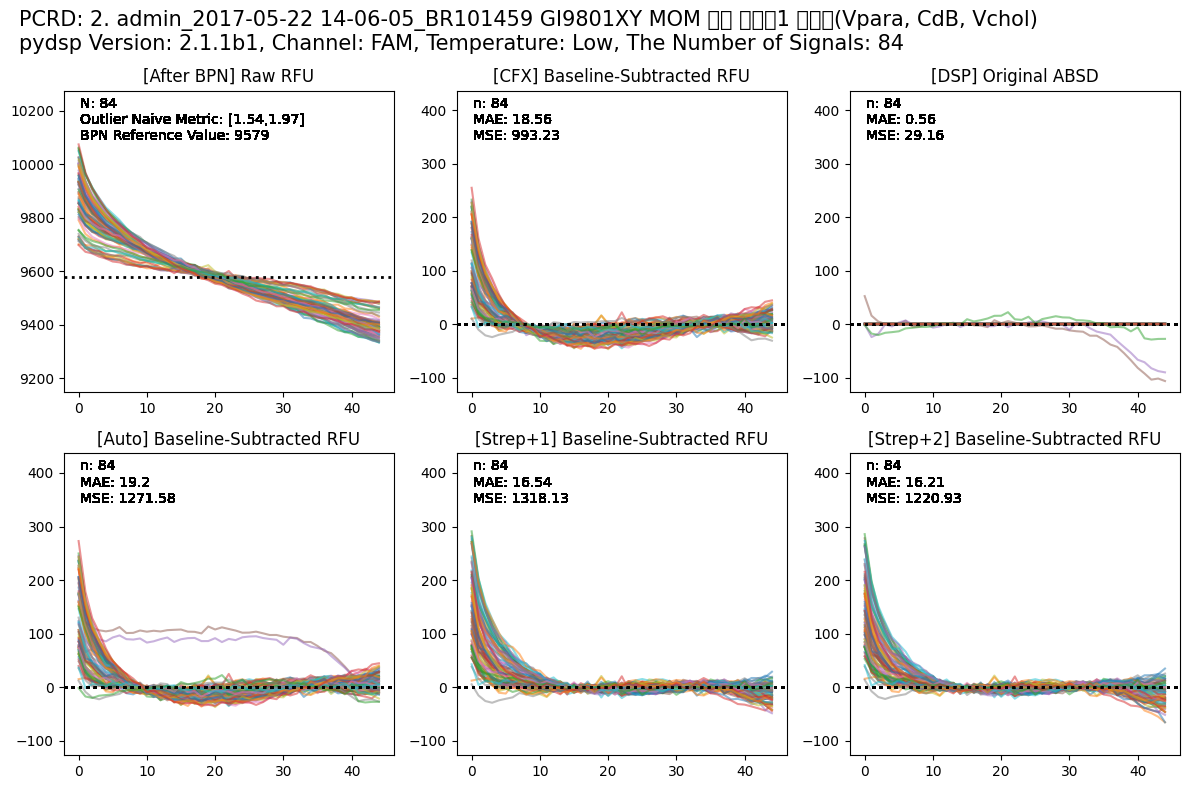

In [33]:
plot_baseline_subtractions(merged_data,pcrd_name,channel_name,temperature_name, mudt=mudt)

### 3. 단일 신호 시각화: 세부 분석 시각화

In [21]:
filtered_data[['well', 'analysis_absd_orig']]

well                                 analysis_absd_orig
0    A01                                                 []
32   A05                                                 []
40   A06                                                 []
56   A08                                                 []
96   B01                                                 []
112  B03                                                 []
120  B04                                                 []
128  B05                                                 []
136  B06                                                 []
152  B08                                                 []
160  B09                                                 []
168  B10                                                 []
176  B11                                                 []
184  B12                                                 []
192  C01                                                 []
224  C05                                                 []
232  C06                                                 []
240  C07                                                 []
248  C08                                                 []
280  C12  [52.668393211020884, 16.200757421080198, 5.136...
296  D02                                                 []
320  D05                                                 []
328  D06                                                 []
344  D08                                                 []
376  D12                                                 []
392  E02                                                 []
400  E03                                                 []
408  E04                                                 []
416  E05                                                 []
424  E06                                                 []
432  E07                                                 []
456  E10                                                 []
472  E12                                                 []
488  F02                                                 []
496  F03                                                 []
504  F04                                                 []
528  F07                                                 []
544  F09                                                 []
552  F10                                                 []
568  F12                                                 []
584  H02                                                 []
592  H03                                                 []
600  H04                                                 []
624  H07                                                 []
640  H09                                                 []
648  H10                                                 []
664  H12                                                 []

/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) miss

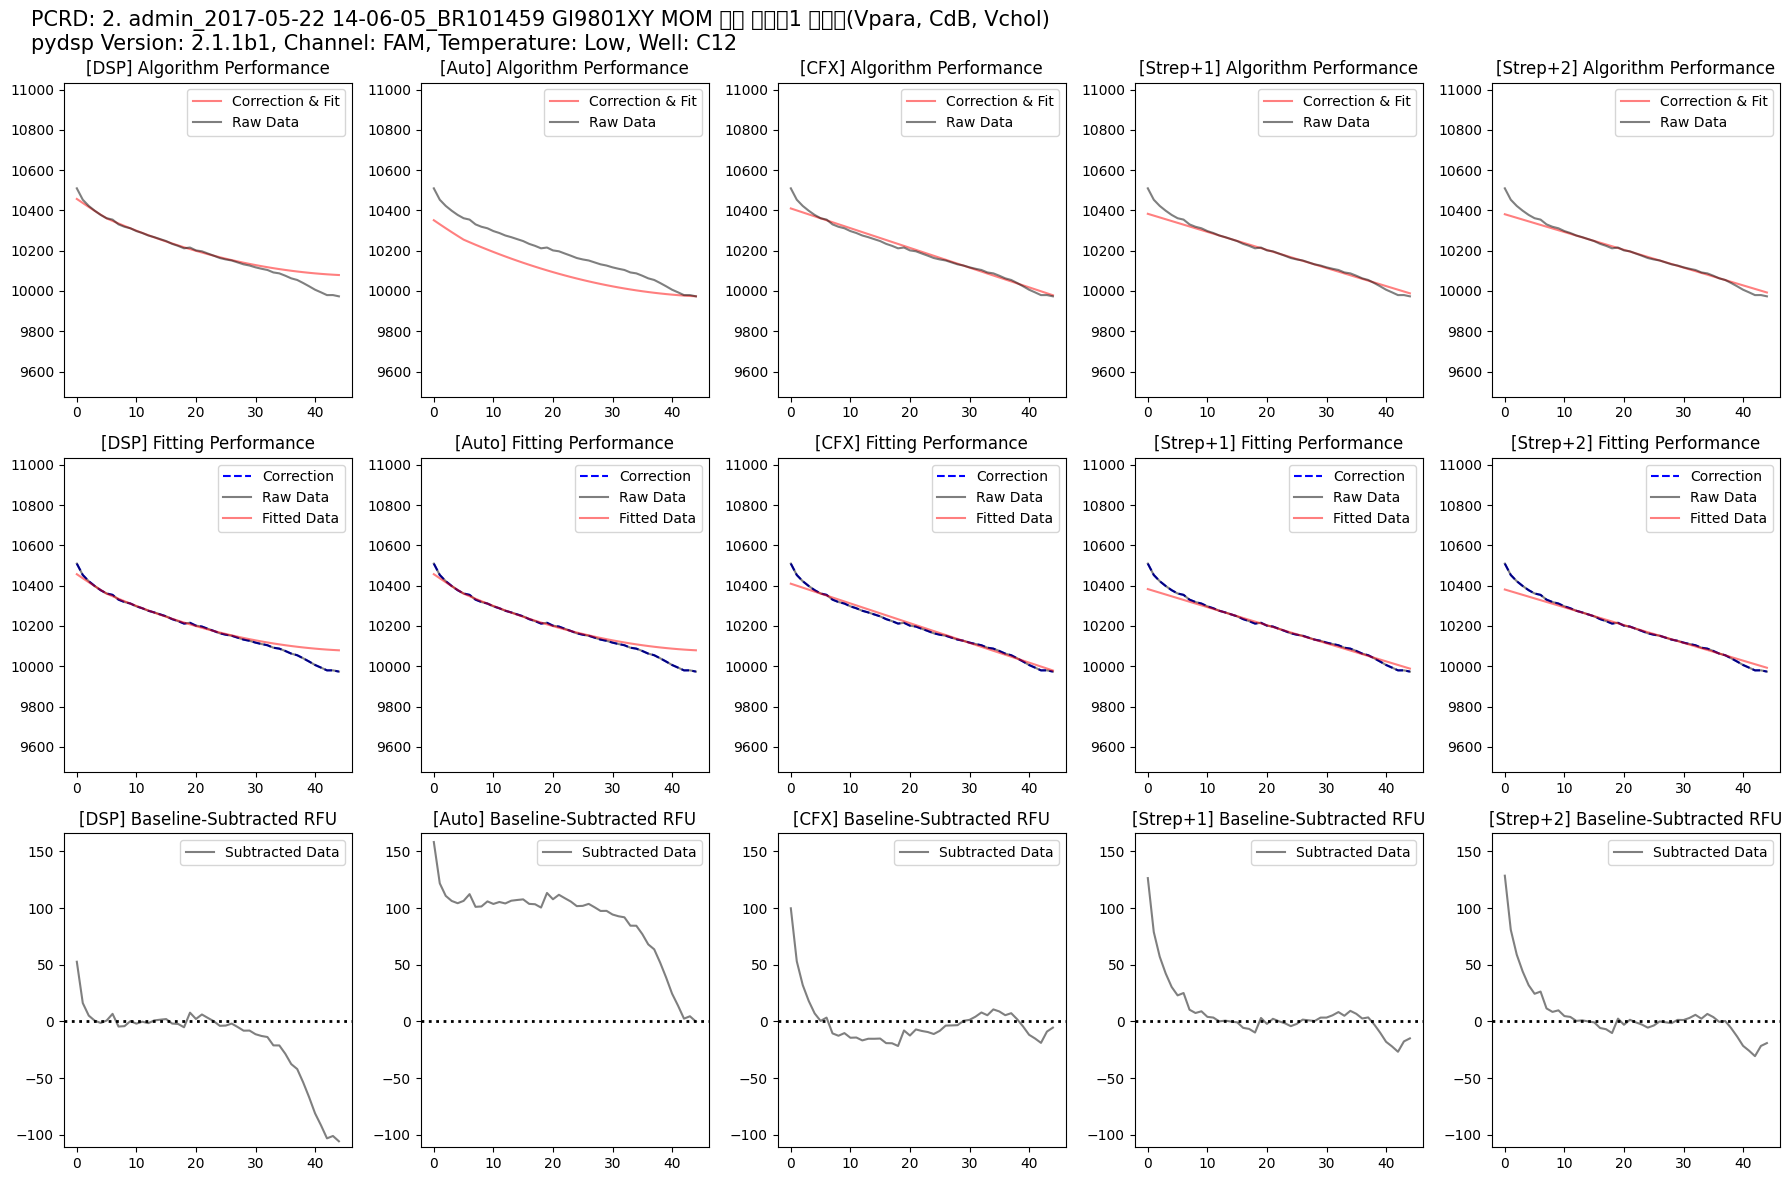

In [22]:
plot_single_well(filtered_data,pcrd_name,channel_name, temperature_name, 'H12',mudt=mudt)

### 4. PGR Manager 시각화

In [ ]:
#'2. admin_2017-05-22 14-06-05_BR101459 GI9801XY MOM 소량 반제품1 민감도(Vpara, CdB, Vchol)'
df = pd.read_parquet('./data/GI-B-I/raw_data/computed/dsp2_generic_config_no-MuDT/dsp/2. admin_2017-05-22 14-06-05_BR101459 GI9801XY MOM 소량 반제품1 민감도(Vpara, CdB, Vchol).dsp.parquet')
p = dspplt.DspResultLegacyPlot(df)
p.plot(well="B12", channel="HEX")

### 5. 증가 신호 패턴에 대한 복수 신호 시각화

In [24]:
ascending_data = merged_data.query("`channel` == @channel_name & `temperature` == @temperature_name & `final_ct` <0 & `linear_slope` >0") #`analysis_dataprocnum` == 13 & 

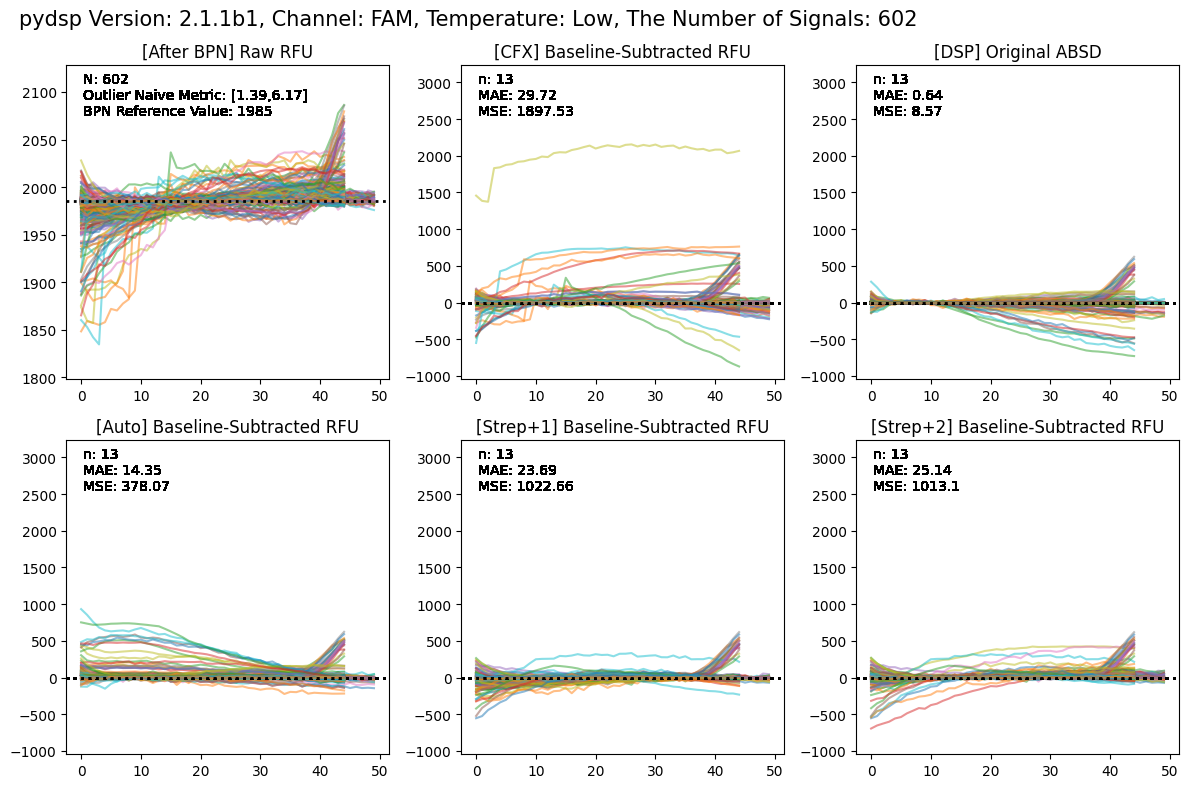

In [6]:
plot_signal_patterns(ascending_data,channel_name, temperature_name, mudt = mudt)

In [25]:
temp=ascending_data[ascending_data['original_rfu_cfx'].apply(lambda x: x[30]>1000)]

In [26]:
pcrd_nm = temp.loc[17632]['name']
channel_nm =temp.loc[17632]['channel']
temperature_nm=temp.loc[17632]['temperature']
well_nm=temp.loc[17632]['well']

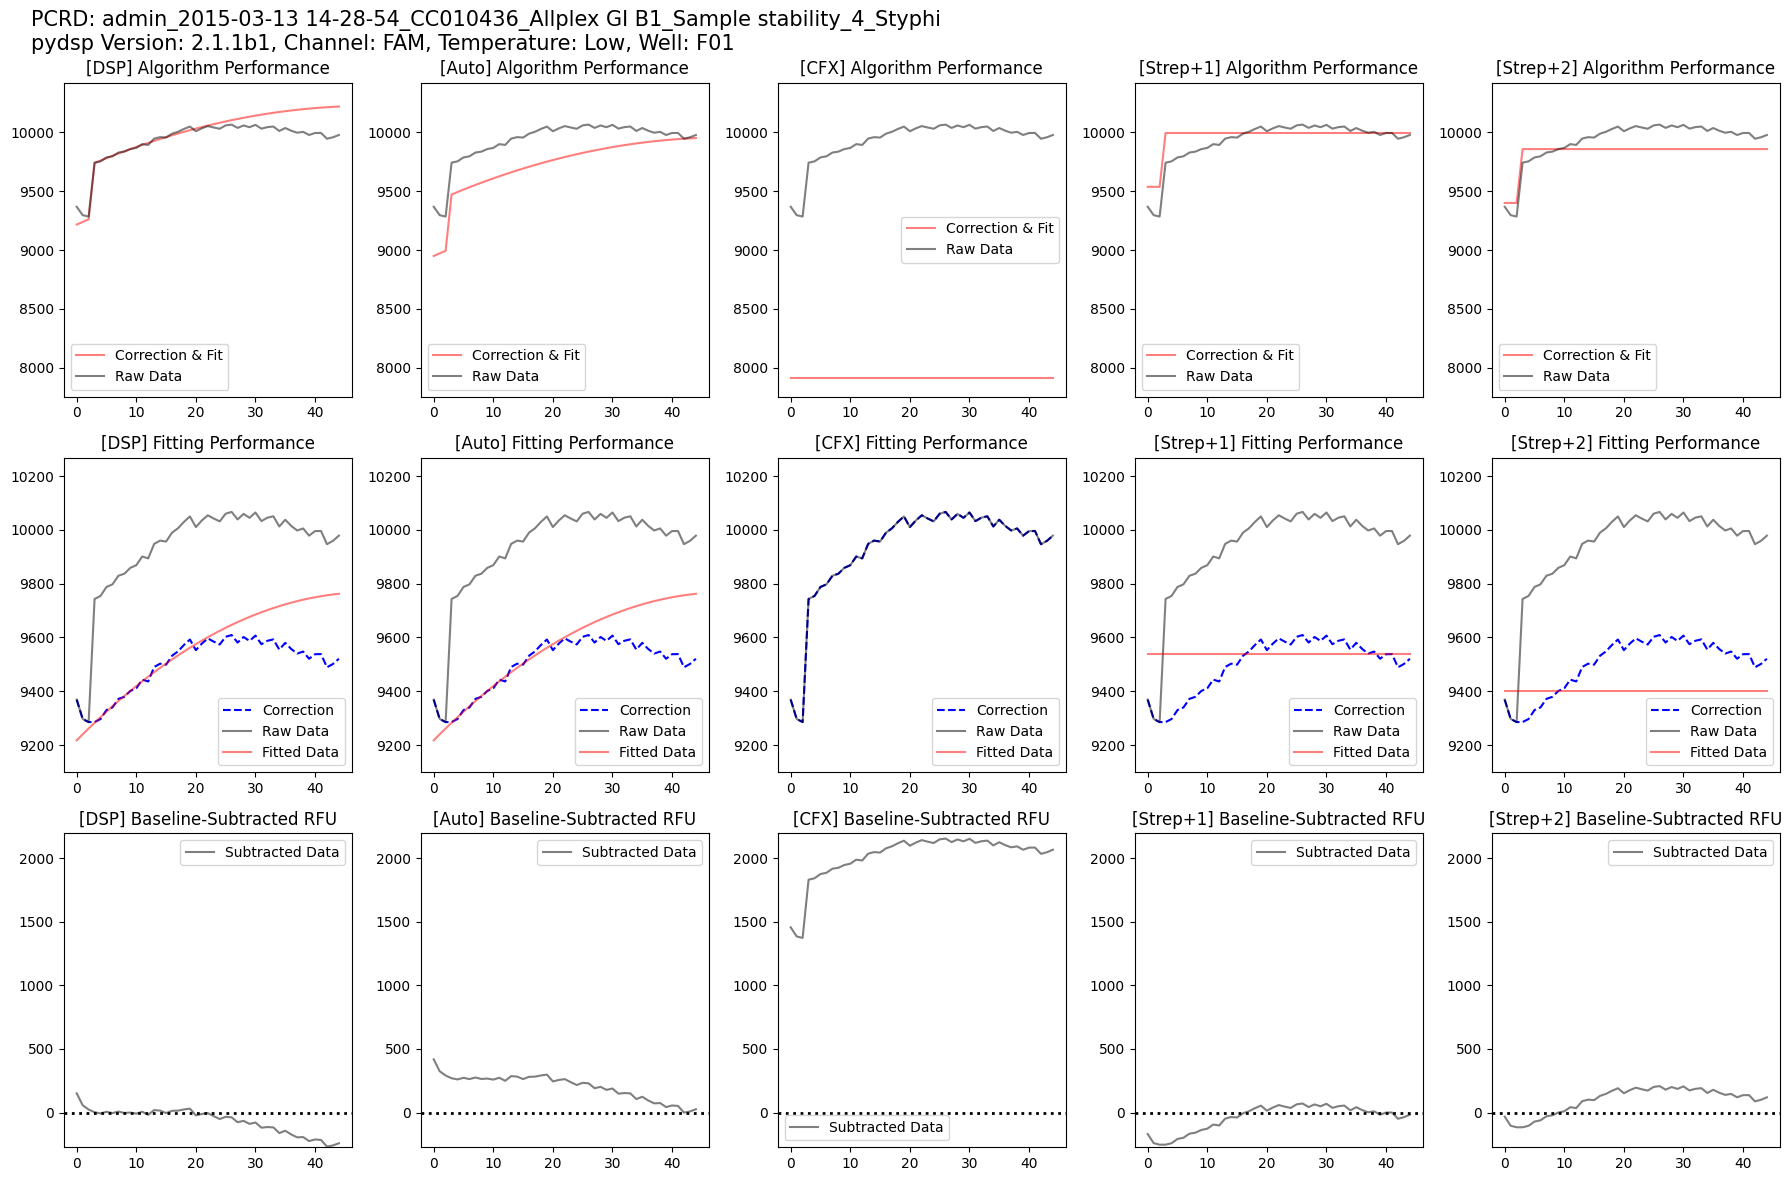

In [9]:
plot_single_well(ascending_data,pcrd_nm,channel_nm,temperature_nm,well_nm,mudt=mudt)

/tmp/ipykernel_192826/3291816010.py:2: DeprecationWarning: DspResultLegacyPlot is deprecated and will be removed in a future version. Use DspResultPlot instead.
  p = dspplt.DspResultLegacyPlot(df)


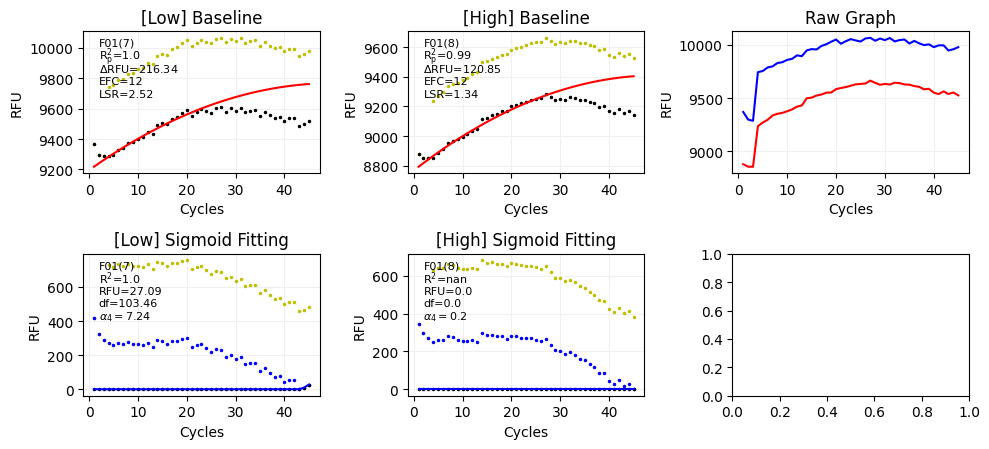

In [27]:
df = pd.read_parquet('./data/GI-B-I/raw_data/computed/dsp2_generic_config_no-MuDT/dsp/' + pcrd_nm + '.dsp.parquet')
p = dspplt.DspResultLegacyPlot(df)
p.plot(well=well_nm, channel=channel_nm)

In [10]:
temp=ascending_data[ascending_data['strep_plus2_analysis_absd'].apply(lambda x: x[41]>200)]

In [11]:
pcrd_nm = temp.loc[18048]['name']
channel_nm =temp.loc[18048]['channel']
temperature_nm=temp.loc[18048]['temperature']
well_nm=temp.loc[18048]['well']

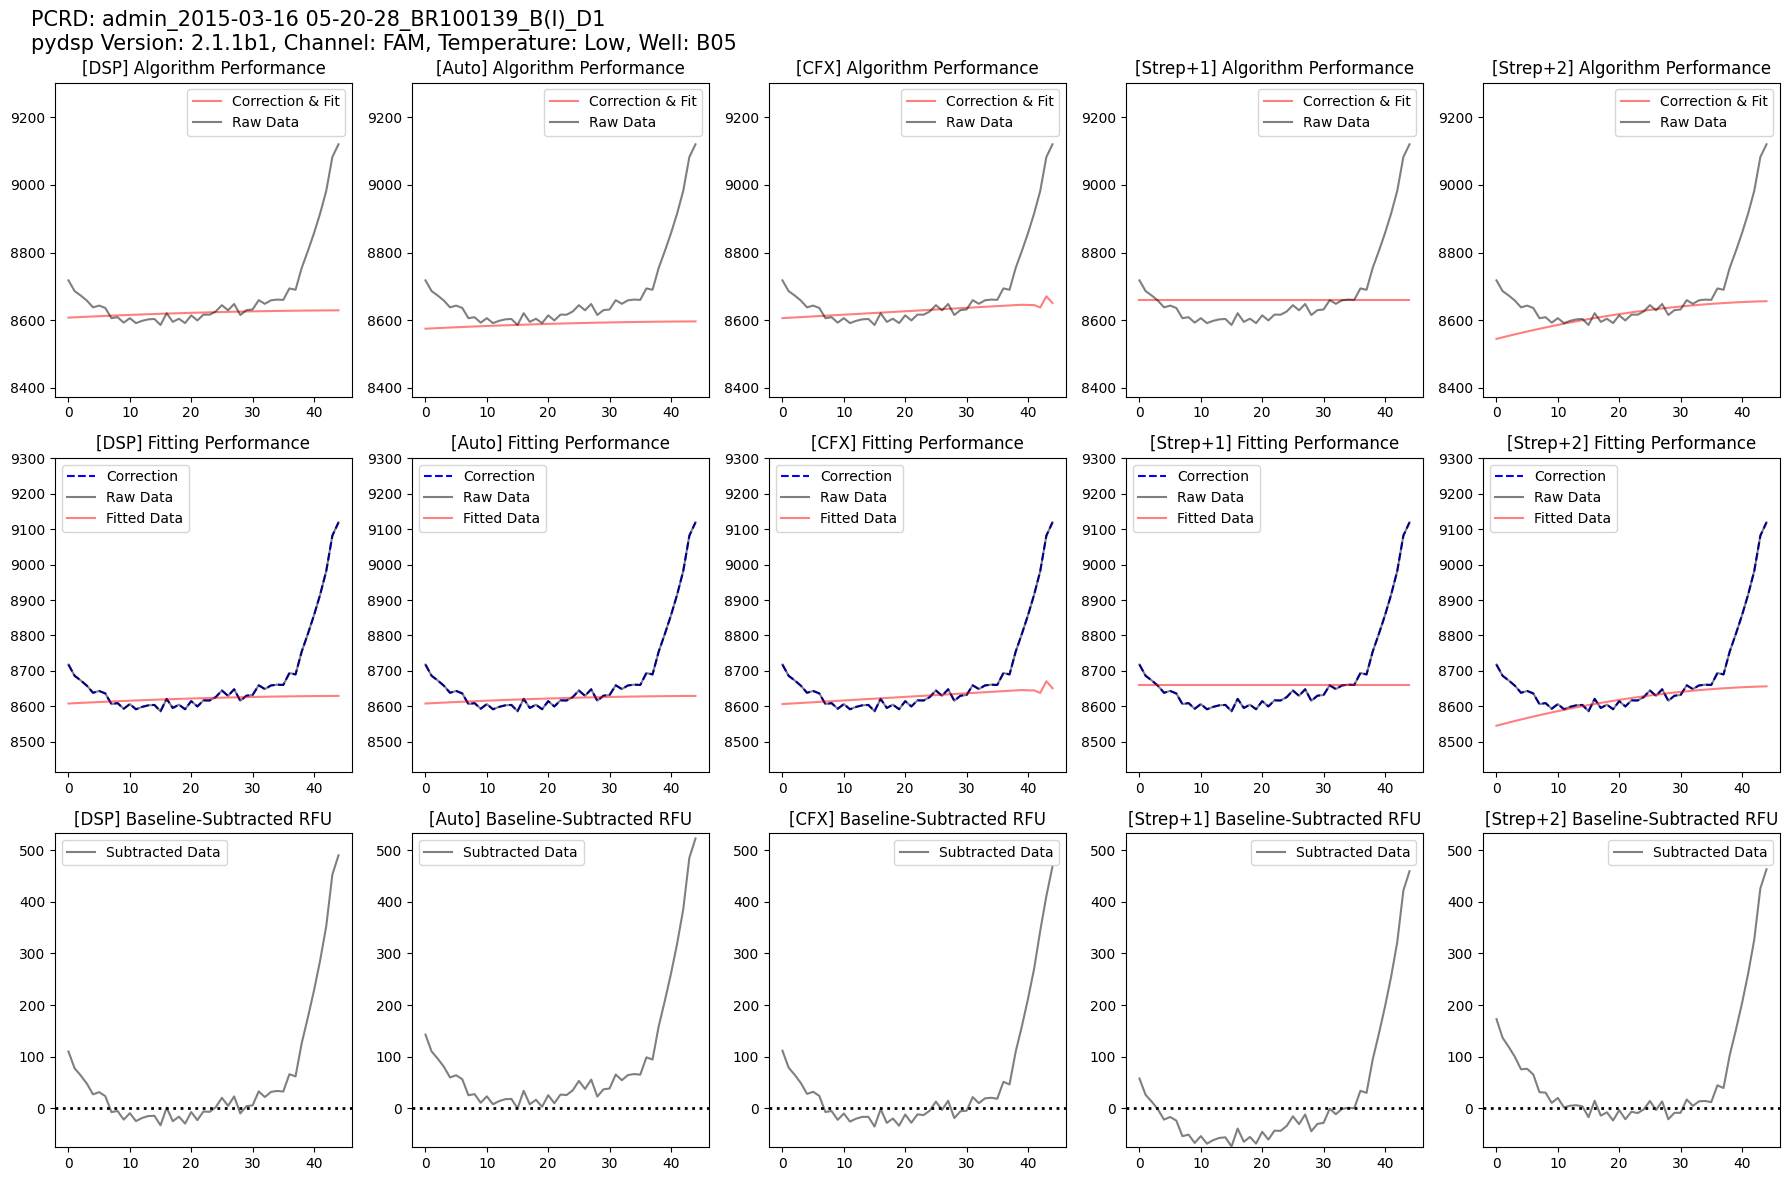

In [12]:
plot_single_well(ascending_data,pcrd_nm,channel_nm,temperature_nm,well_nm,mudt=mudt)

/tmp/ipykernel_188795/608924134.py:3: DeprecationWarning: DspResultLegacyPlot is deprecated and will be removed in a future version. Use DspResultPlot instead.
  p = dspplt.DspResultLegacyPlot(df)


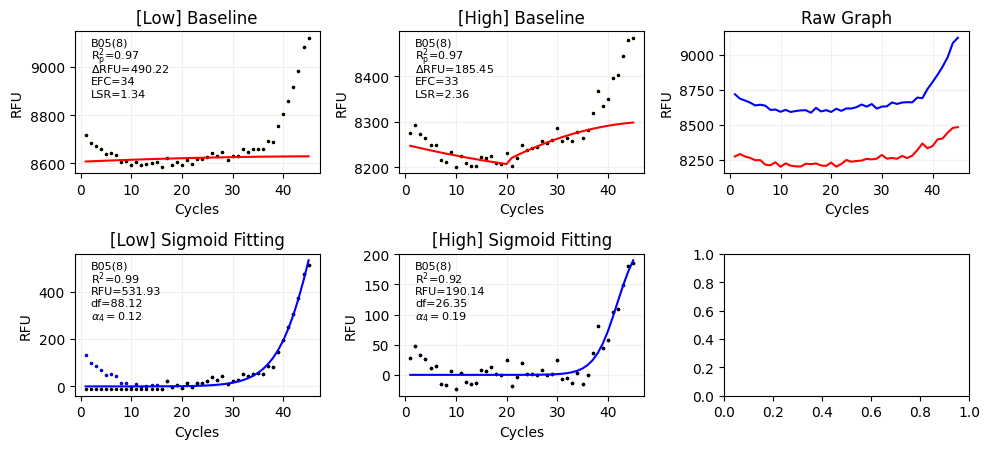

In [14]:
df = pd.read_parquet('./data/GI-B-I/raw_data/computed/dsp2_generic_config_no-MuDT/dsp/' + pcrd_nm + '.dsp.parquet')
p = dspplt.DspResultLegacyPlot(df)
p.plot(well=well_nm, channel=channel_nm)

### 6. 감소 신호 패턴에 대한 복수 신호 시각화

In [13]:
descending_data = merged_data.query("`analysis_dataprocnum` == 13 & `channel` == @channel_name & `temperature` == @temperature_name & `final_ct` <0 & `linear_slope` <0")
descending_data=descending_data.iloc[:len(descending_data) // 2]

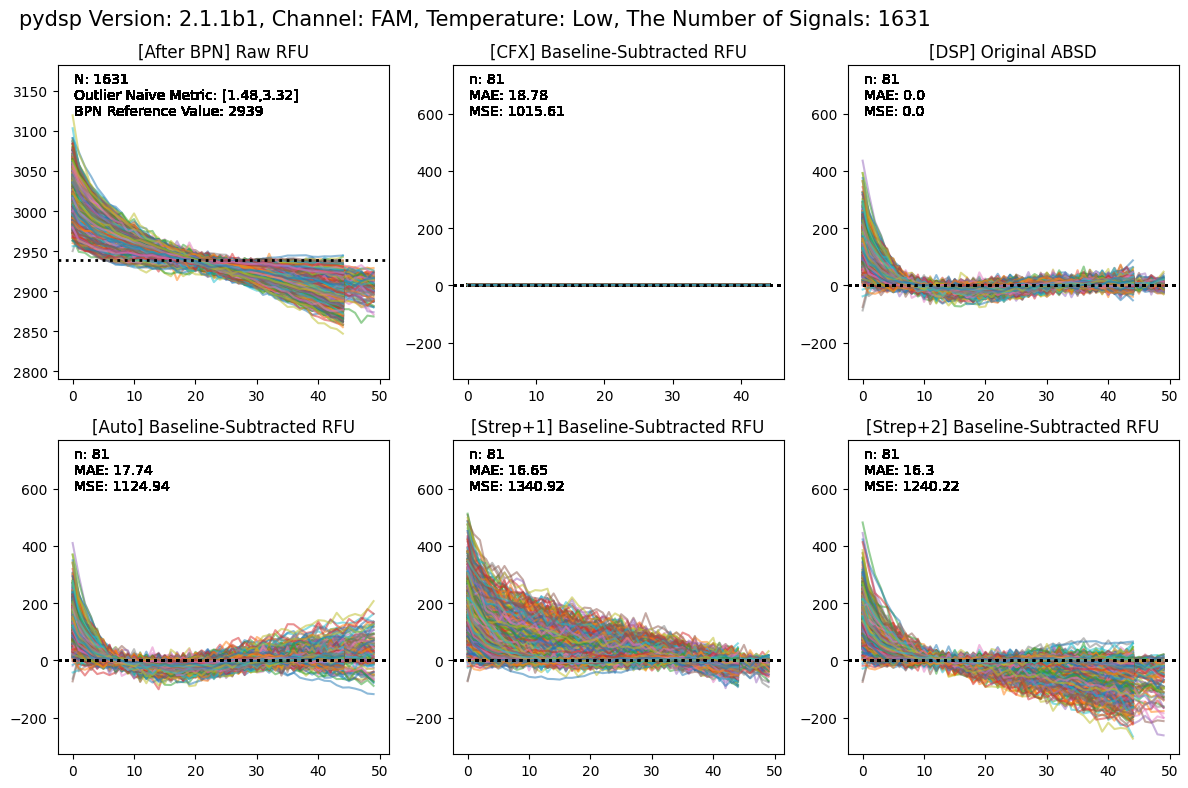

In [19]:
plot_signal_patterns(descending_data,channel_name, temperature_name, mudt = mudt)

In [14]:
temp=descending_data[descending_data['strep_plus1_analysis_absd'].apply(lambda x: x[12]>200)]
temp

original_rfu_cfx  \
5272   [190.130916521426, 113.452241329114, 68.405979...   
18016  [119.270712169618, 50.4348900039222, 29.891451...   
20728  [165.785021697026, 53.8448341108924, 41.145510...   
22048  [155.356999831642, 87.8688536913669, 53.203620...   
36000  [28.963892568825, 9.72653757220723, 40.2708494...   
37592  [156.722931177694, 118.961945472467, 106.16674...   

                                               combo_key  \
5272   admin_2015-02-24 10-10-34_BR100159_Allplex GI_...   
18016  admin_2015-03-16 05-20-28_BR100139_B(I)_D1 8-s...   
20728  admin_2015-03-17 17-35-09_BR100136_Allplex GI ...   
22048  admin_2015-03-18 21-31-56_BR100139_B(I)_D2_1 8...   
36000  admin_2015-04-16 10-58-14_CC013751_REPEAT_b(I)...   
37592  admin_2015-04-21 15-22-47_BR100136_GI_B1_In-us...   

                                                    name   steps pcr_system  \
5272   admin_2015-02-24 10-10-34_BR100159_Allplex GI_...  [4, 5]       None   
18016         admin_2015-03-16 05-20-28_BR100139_B(I)_D1  [4, 5]       None   
20728  admin_2015-03-17 17-35-09_BR100136_Allplex GI ...  [4, 5]       None   
22048       admin_2015-03-18 21-31-56_BR100139_B(I)_D2_1  [4, 5]       None   
36000  admin_2015-04-16 10-58-14_CC013751_REPEAT_b(I)...  [4, 5]       None   
37592  admin_2015-04-21 15-22-47_BR100136_GI_B1_In-us...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
5272     8-strip   Sample  E04     FAM         Low  ...   
18016    8-strip   Sample  B01     FAM         Low  ...   
20728    8-strip   Sample  F04     FAM         Low  ...   
22048    8-strip   Sample  D01     FAM         Low  ...   
36000    8-strip   Sample  A08     FAM         Low  ...   
37592    8-strip   Sample  F02     FAM         Low  ...   

                            strep_plus2_analysis_scd_fit  \
5272   [8963.3217651414, 8963.3217651414, 8963.321765...   
18016  [9724.79322563995, 9724.79322563995, 9724.7932...   
20728  [10520.55752798, 10520.55752798, 10520.5575279...   
22048  [10551.2757395542, 10551.2757395542, 10551.275...   
36000  [11505.9535486838, 11505.9535486838, 11505.953...   
37592  [9819.22492378247, 9819.22492378247, 9819.2249...   

       strep_plus2_analysis_efc strep_plus2_final_ct  \
5272                         48                 -1.0   
18016                        43                 -1.0   
20728                        43                 -1.0   
22048                        43                 -1.0   
36000                        43                 -1.0   
37592                        43                 -1.0   

      strep_plus2_analysis_resultwell  strep_plus2_analysis_dataprocnum  \
5272                                1                                 8   
18016                               1                                 8   
20728                               1                                 8   
22048                               1                                 8   
36000                               1                                 8   
37592                               1                                 8   

                    outlier_naive_residuals_original_rfu  \
5272   [9257.20745041051, 9173.06478321469, 9120.5545...   
18016  [9948.75932018646, 9873.1337026382, 9845.80046...   
20728  [10797.0877149652, 10677.2571727382, 10656.667...   
22048  [10812.8711511812, 10737.1401669222, 10694.232...   
36000  [11639.5666533362, 11612.7062815258, 11635.627...   
37592  [10105.2821513174, 10059.4928245328, 10038.669...   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
5272                            1.689391                           2.412454   
18016                           1.656100                           2.412454   
20728                           1.767046                           2.412454   
22048                           1.713208                           2.412454   
36000                           1.576389                           2.41245

In [15]:
pcrd_nm = temp.loc[5272]['name']
channel_nm =temp.loc[5272]['channel']
temperature_nm=temp.loc[5272]['temperature']
well_nm=temp.loc[5272]['well']

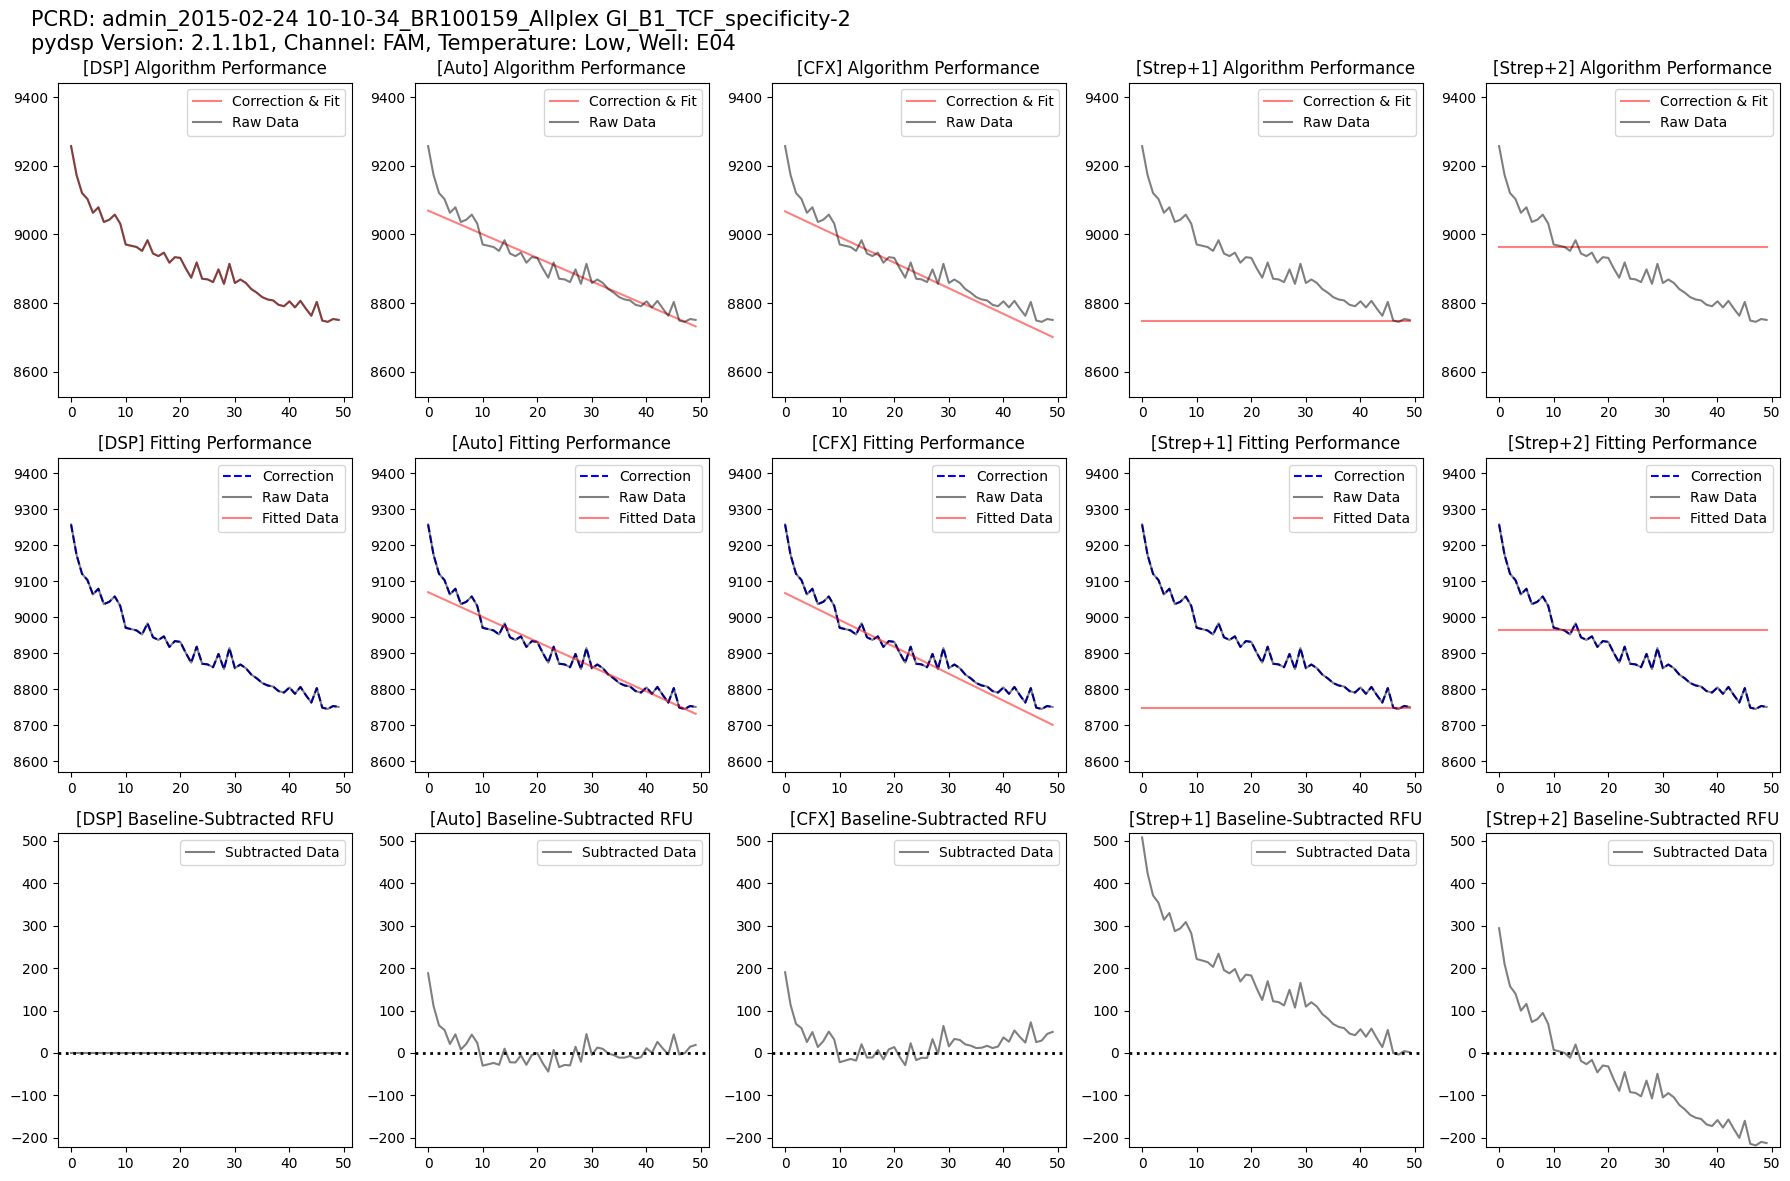

In [16]:
plot_single_well(descending_data,pcrd_nm,channel_nm,temperature_nm,well_nm,mudt=mudt)

In [17]:
temp=descending_data[descending_data['strep_plus2_analysis_absd'].apply(lambda x: x[31]>50)]
temp

original_rfu_cfx  \
18528  [230.820144349607, 180.536692518428, 120.23182...   
26384  [246.651024212762, 163.078960788114, 118.62214...   
32640  [205.818948096259, 96.3987962359442, 86.507907...   

                                               combo_key  \
18528  admin_2015-03-16 05-20-28_BR100139_B(I)_D1 8-s...   
26384  admin_2015-03-25 08-32-59_CC013751_B(I)_D5 8-s...   
32640  admin_2015-04-07 13-49-58_BR100136_GI_B1_ACC_V...   

                                                    name   steps pcr_system  \
18528         admin_2015-03-16 05-20-28_BR100139_B(I)_D1  [4, 5]       None   
26384         admin_2015-03-25 08-32-59_CC013751_B(I)_D5  [4, 5]       None   
32640  admin_2015-04-07 13-49-58_BR100136_GI_B1_ACC_V...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
18528    8-strip   Sample  G05     FAM         Low  ...   
26384    8-strip   Sample  C11     FAM         Low  ...   
32640    8-strip   Sample  F07     FAM         Low  ...   

                            strep_plus2_analysis_scd_fit  \
18528  [9600.011208003702, 9591.863488218056, 9583.88...   
26384  [12525.315315123746, 12508.851596242355, 12492...   
32640  [9492.963003224706, 9485.780975170306, 9478.59...   

       strep_plus2_analysis_efc strep_plus2_final_ct  \
18528                        24                 -1.0   
26384                        39                 -1.0   
32640                        28                 -1.0   

      strep_plus2_analysis_resultwell  strep_plus2_analysis_dataprocnum  \
18528                               1                                 8   
26384                               1                                 8   
32640                               1                                 8   

                    outlier_naive_residuals_original_rfu  \
18528  [9820.80187820294, 9766.78857467231, 9702.7538...   
26384  [12761.500435413, 12667.2022361139, 12612.0192...   
32640  [9719.99582320024, 9603.60437856128, 9586.7421...   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
18528                           2.246824                           2.412454   
26384                           1.820746                           2.412454   
32640                           1.987431                           2.412454   

       outlier_naive_metric_percentile_original_rfu linear_slope  
18528                                          90.0    -0.115107  
26384                                          56.3    -0.074005  
32640                                          76.1    -0.108811  

[3 rows x 89 columns]

In [18]:
pcrd_nm = temp.loc[18528]['name']
channel_nm =temp.loc[18528]['channel']
temperature_nm=temp.loc[18528]['temperature']
well_nm=temp.loc[18528]['well']

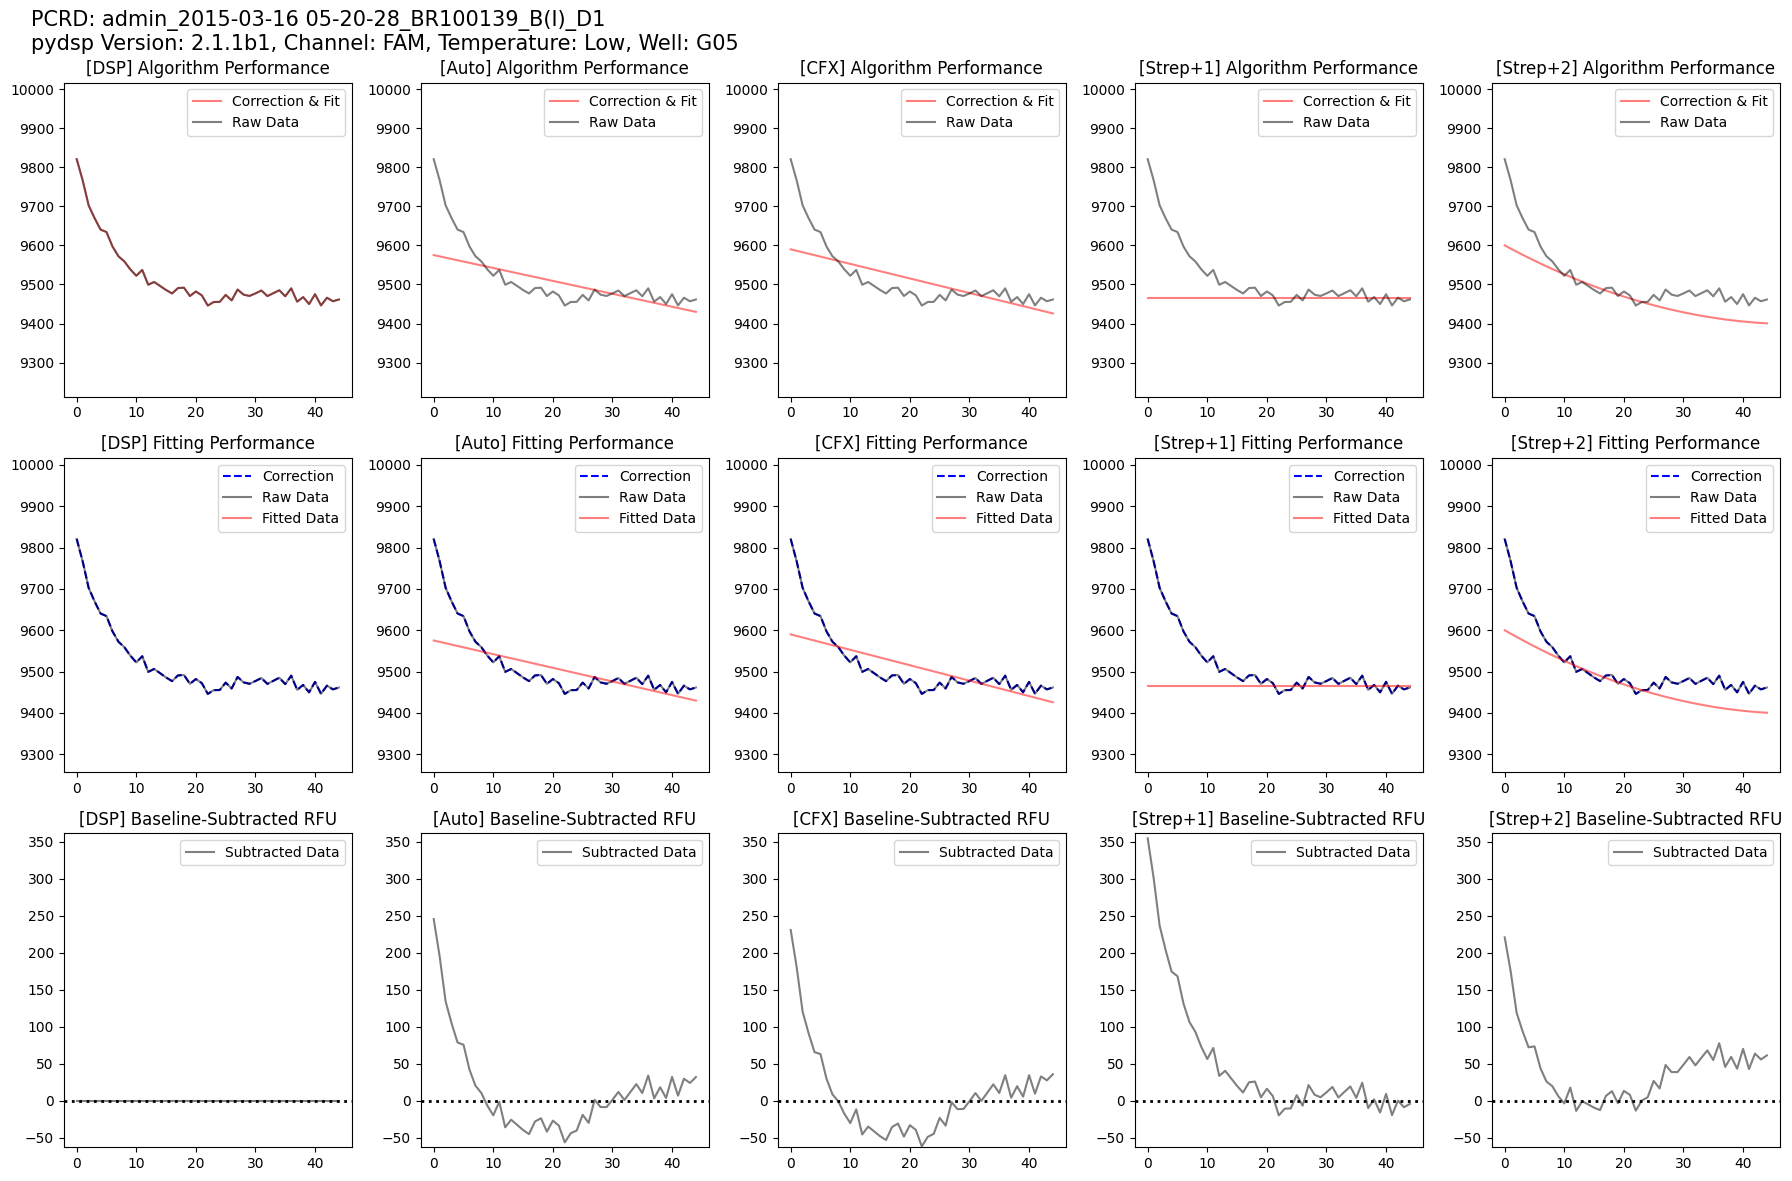

In [19]:
plot_single_well(descending_data,pcrd_nm,channel_nm,temperature_nm,well_nm,mudt=mudt)

## 2. Analysis with MuDT

### 1. Data Preparation

In [6]:
mudt=True
outlier_naive_metric =1.65
result_data = main_function(outlier_naive_metric,mudt)
merged_data = result_data[0]
filtered_data = result_data[1]

channels=filtered_data['channel'].unique()
temperatures=filtered_data['temperature'].unique()
plate_names=filtered_data['name'].unique()
well_names=filtered_data['well'].unique()
colors = {'Low':'blue','High':'red'}
pcrd_name = filtered_data['name'].unique()[0]
channel_name = filtered_data['channel'].unique()[0]
temperature_name = filtered_data['temperature'].unique()[0]

[13  6  0  3  8  5  4  7 -3 -2  9 10  2]


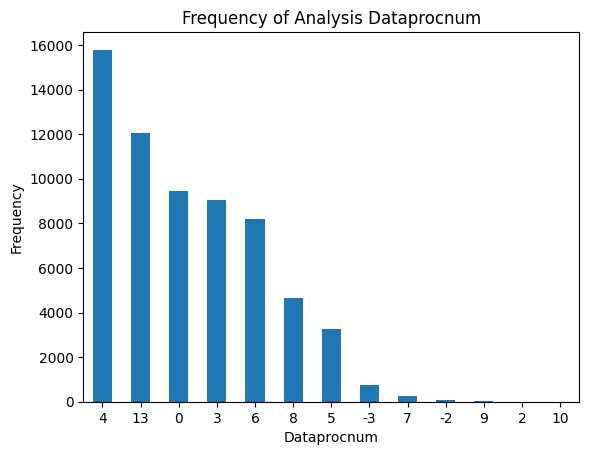

In [7]:
print(merged_data['analysis_dataprocnum'].unique())
frequency_counts = merged_data['analysis_dataprocnum'].value_counts()
frequency_counts.plot(kind='bar')
plt.title('Frequency of Analysis Dataprocnum')
plt.xlabel('Dataprocnum')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical for readability
plt.show()

### 2. Plate 단위 시각화

/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:306: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:306: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:306: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:306: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:306: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:306: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) miss

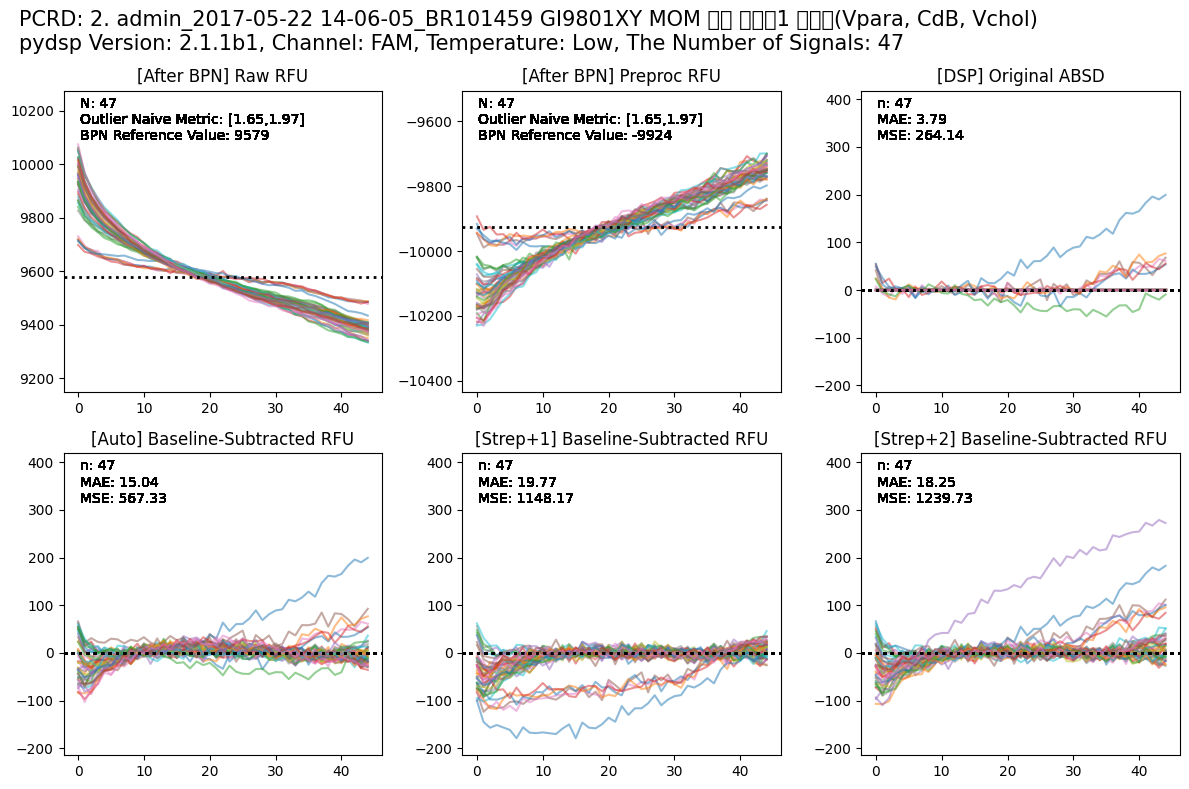

In [19]:
plot_baseline_subtractions(filtered_data,pcrd_name,channel_name,temperature_name, mudt=mudt)

### 3. 단일 신호 시각화: 세부 분석 시각화

In [6]:
temp=filtered_data[filtered_data['strep_plus2_analysis_absd'].apply(lambda x: x[20]>100)]
temp

original_rfu_cfx  \
640  [191.40472828131, 121.471362422002, 87.5023230...   

                                             combo_key  \
640  2. admin_2017-05-22 14-06-05_BR101459 GI9801XY...   

                                                  name   steps pcr_system  \
640  2. admin_2017-05-22 14-06-05_BR101459 GI9801XY...  [4, 5]       None   

    consumable welltype well channel temperature  ...  \
640    8-strip       NC  H09     FAM         Low  ...   

                          strep_plus2_analysis_scd_fit  \
640  [-9477.270311337621, -9477.270311337621, -9477...   

     strep_plus2_analysis_efc strep_plus2_final_ct  \
640                         9                 -1.0   

    strep_plus2_analysis_resultwell  strep_plus2_analysis_dataprocnum  \
640                               1                                 8   

                  outlier_naive_residuals_original_rfu  \
640  [10571.8091141078, 10492.1901480909, 10448.535...   

     outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
640                           1.908849                           2.412454   

     outlier_naive_metric_percentile_original_rfu linear_slope  
640                                          68.3     0.116052  

[1 rows x 89 columns]

In [9]:
pcrd_nm = temp.loc[640]['name']
channel_nm =temp.loc[640]['channel']
temperature_nm=temp.loc[640]['temperature']
well_nm=temp.loc[640]['well']
print(pcrd_nm)
print(channel_nm)
print(temperature_nm)
print(well_nm)

2. admin_2017-05-22 14-06-05_BR101459 GI9801XY MOM 소량 반제품1 민감도(Vpara, CdB, Vchol)
FAM
Low
H09


/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) miss

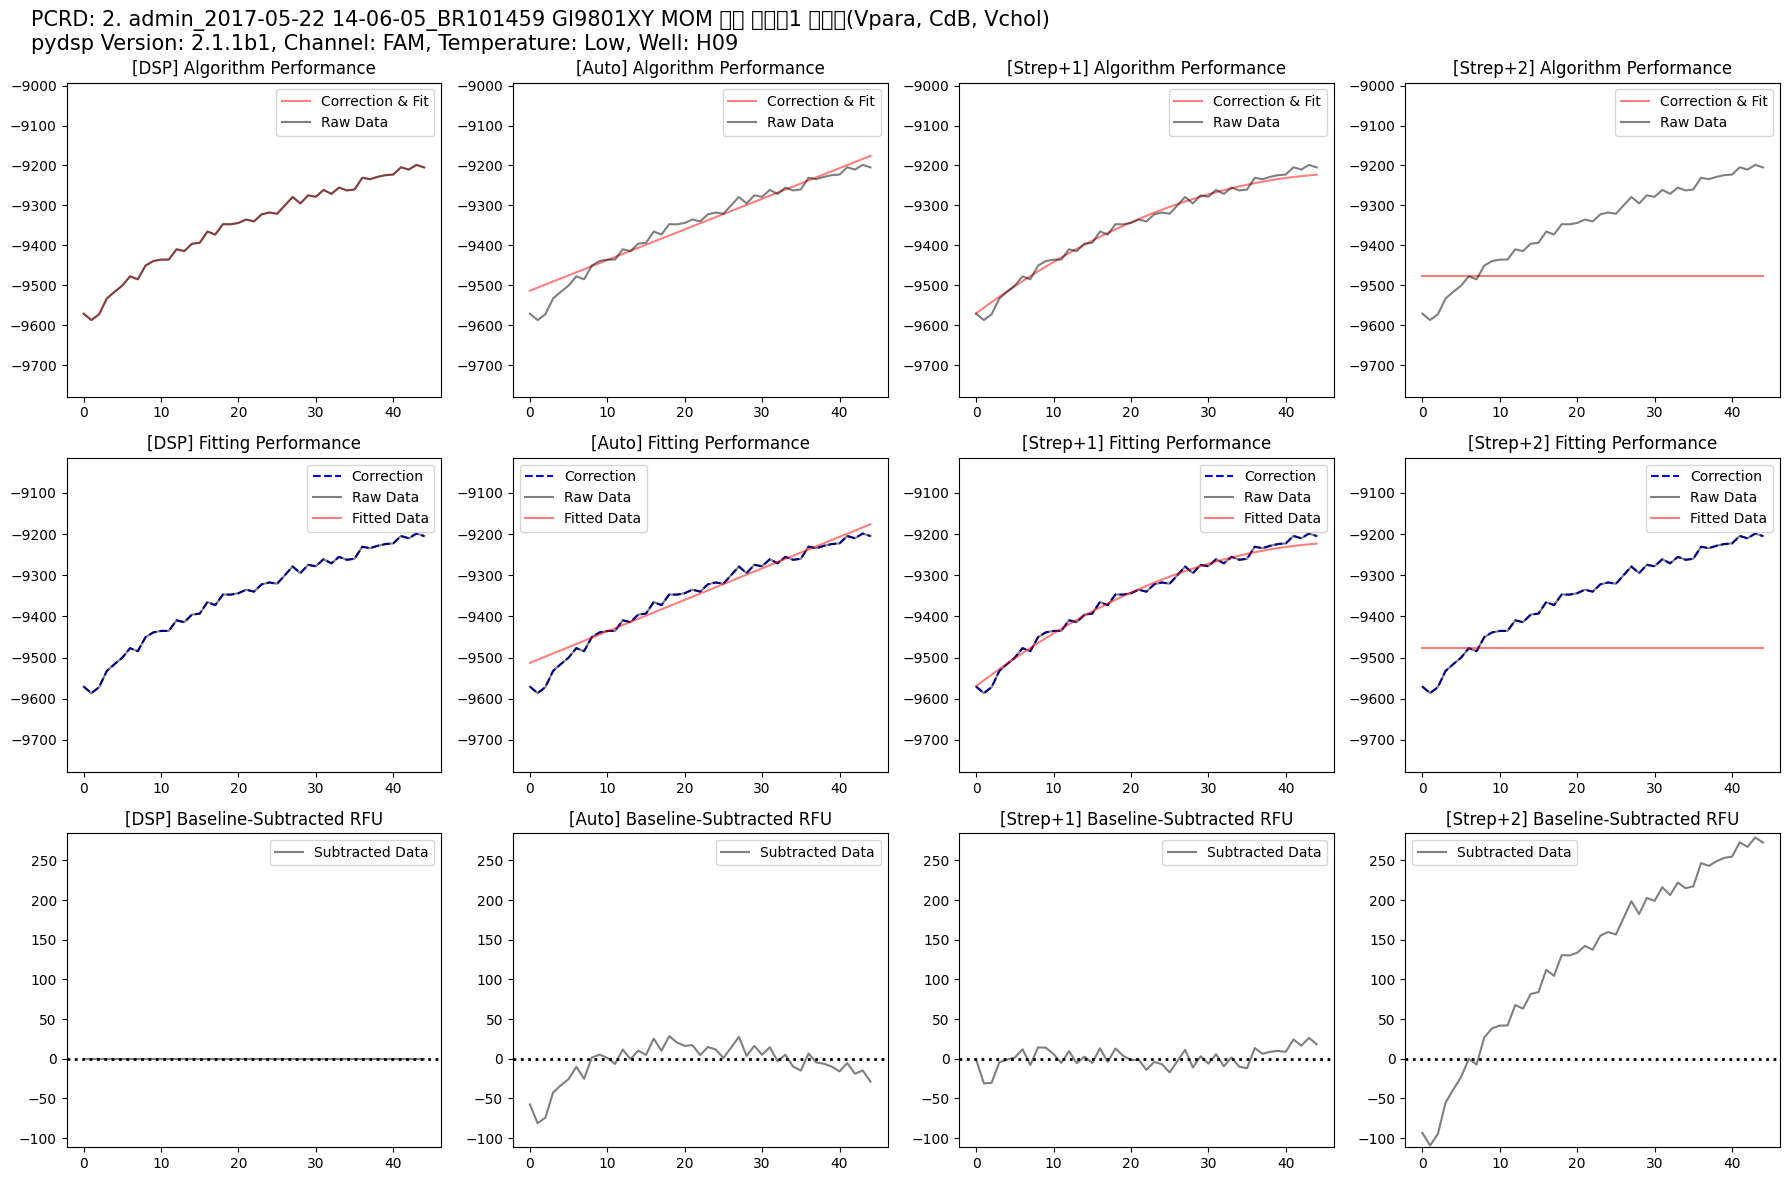

In [23]:
plot_single_well(filtered_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

### 4. PGR Manager 시각화

/tmp/ipykernel_198468/1607697860.py:2: DeprecationWarning: DspResultLegacyPlot is deprecated and will be removed in a future version. Use DspResultPlot instead.
  p = dspplt.DspResultLegacyPlot(df)


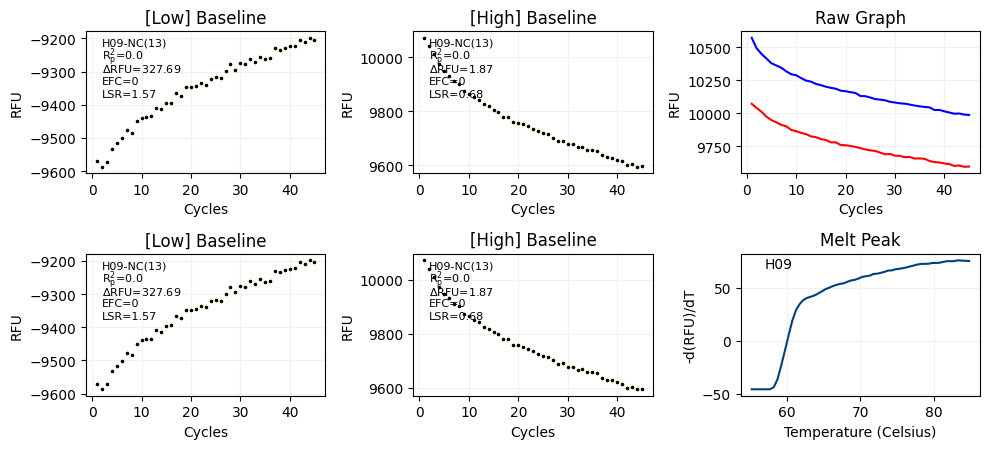

In [11]:
df = pd.read_parquet('./data/GI-B-I/raw_data/computed/dsp2_generic_config_MuDT/dsp/' + pcrd_nm + '.dsp.parquet')
p = dspplt.DspResultLegacyPlot(df)
p.plot(well=well_nm, channel=channel_nm)

### 5. 증가 신호 패턴에 대한 복수 신호 시각화

In [24]:
ascending_data = merged_data.query("`analysis_dataprocnum` == 13 & `channel` == @channel_name & `temperature` == @temperature_name & `final_ct` <0 & `linear_slope` >0")
ascending_data = ascending_data.iloc[:len(ascending_data) // 2]

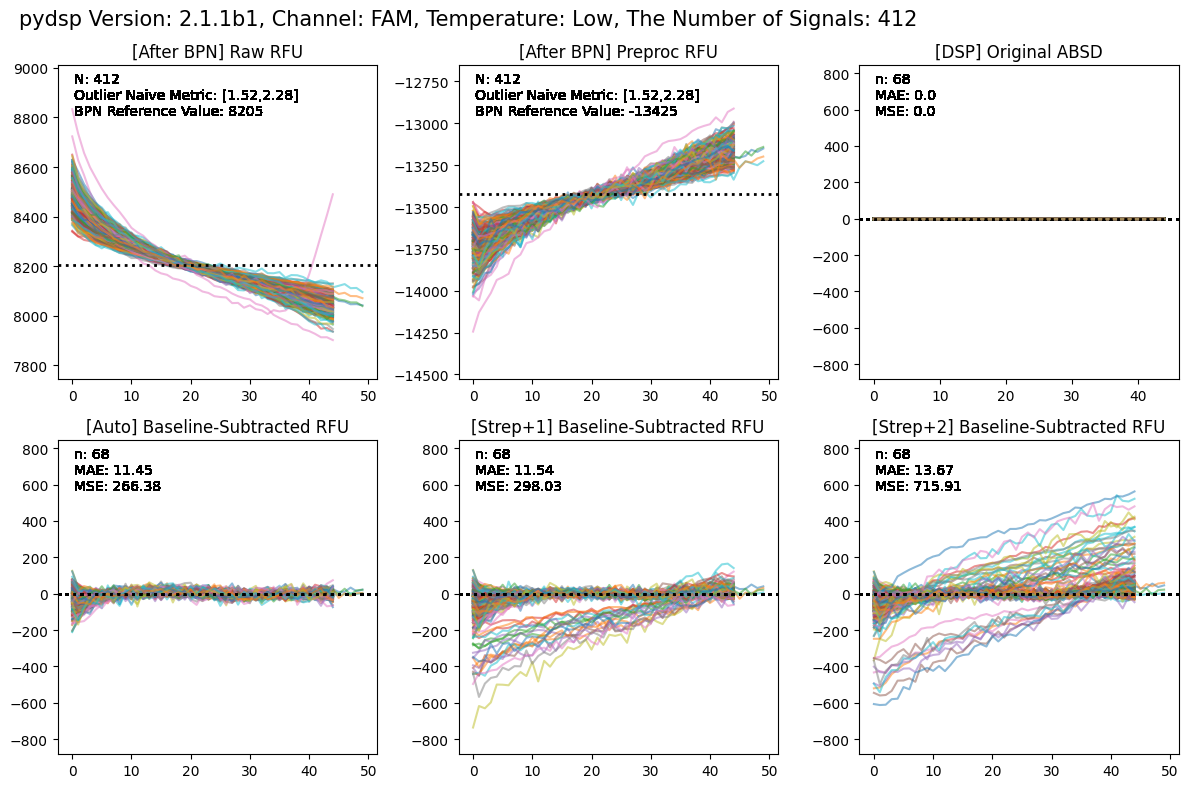

In [13]:
plot_signal_patterns(ascending_data,channel_name, temperature_name, mudt = mudt)

In [38]:
temp=ascending_data[ascending_data['strep_plus1_analysis_absd'].apply(lambda x: x[10]<-200)]
pcrd_nm = temp.loc[1528]['name']
channel_nm =temp.loc[1528]['channel']
temperature_nm=temp.loc[1528]['temperature']
well_nm=temp.loc[1528]['well']

/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:456: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) miss

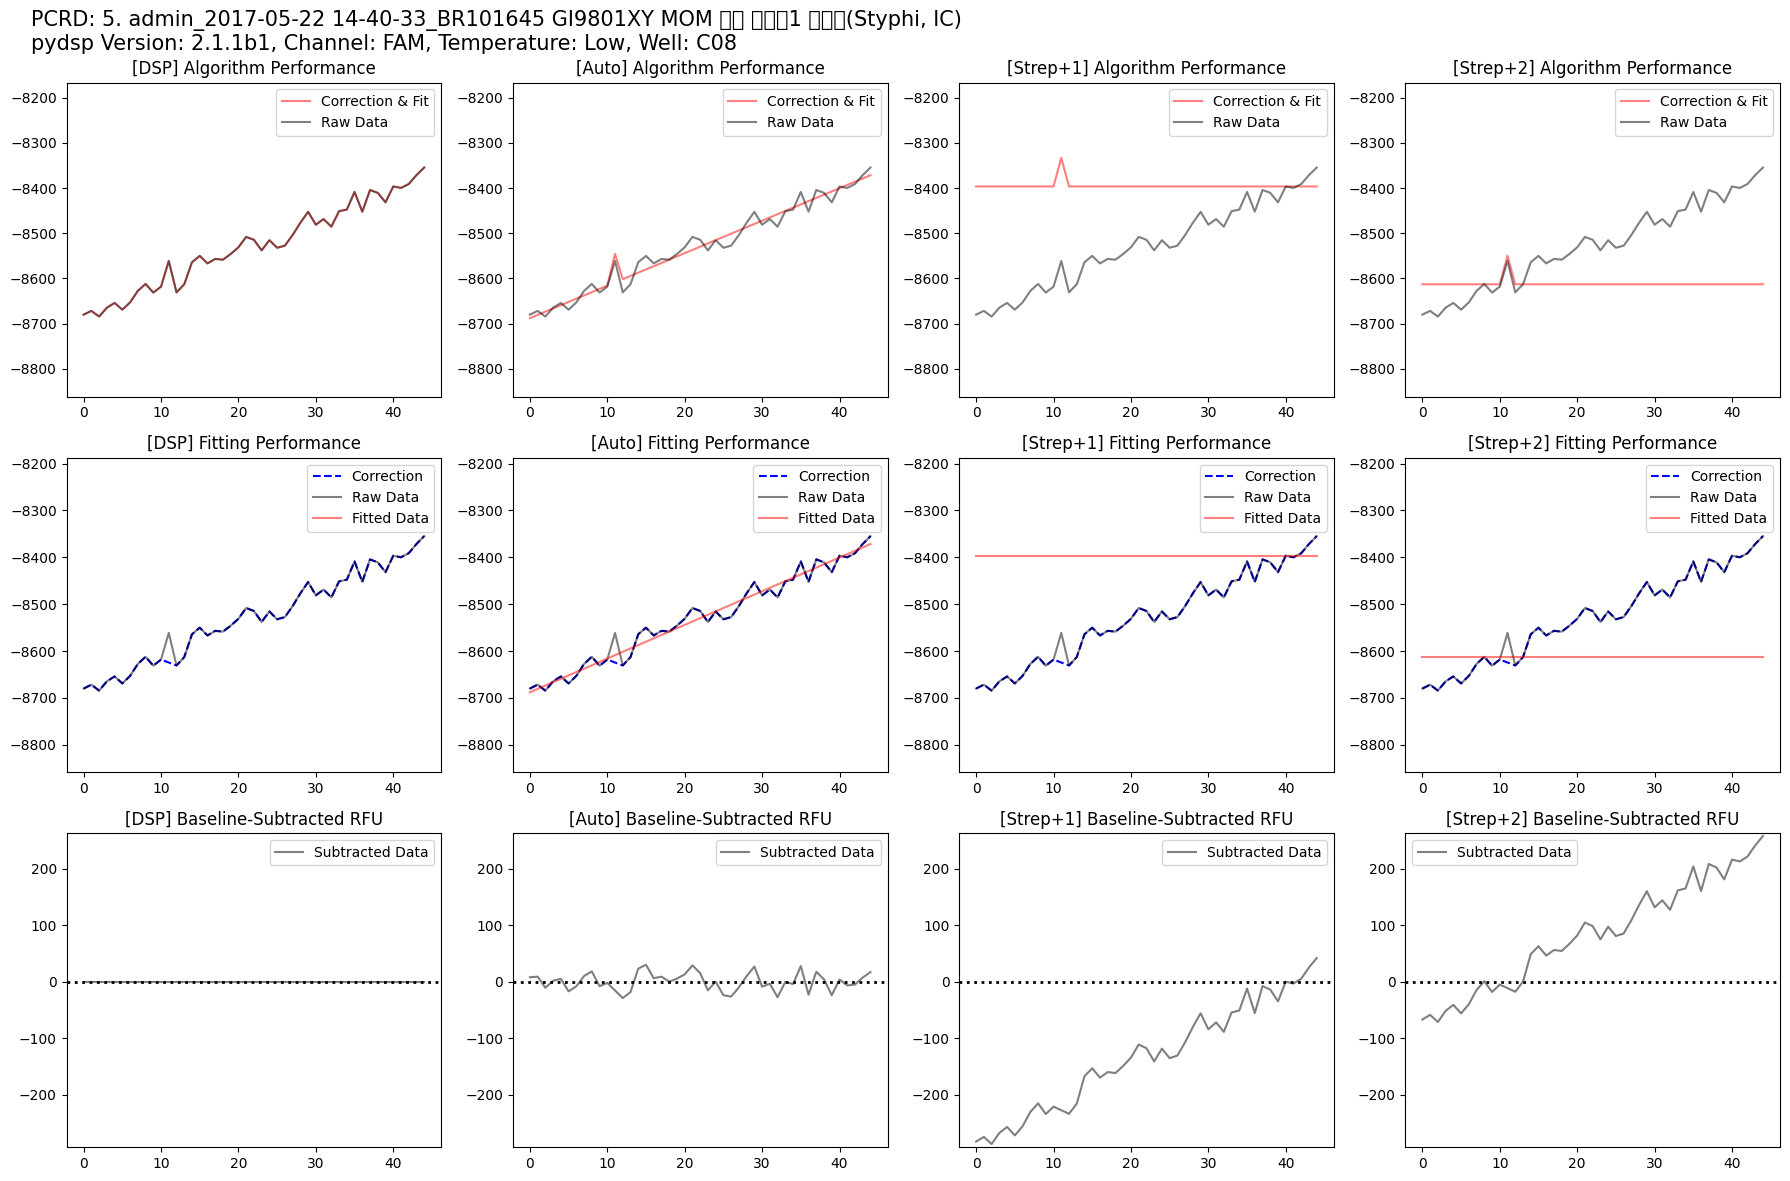

In [31]:
plot_single_well(ascending_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

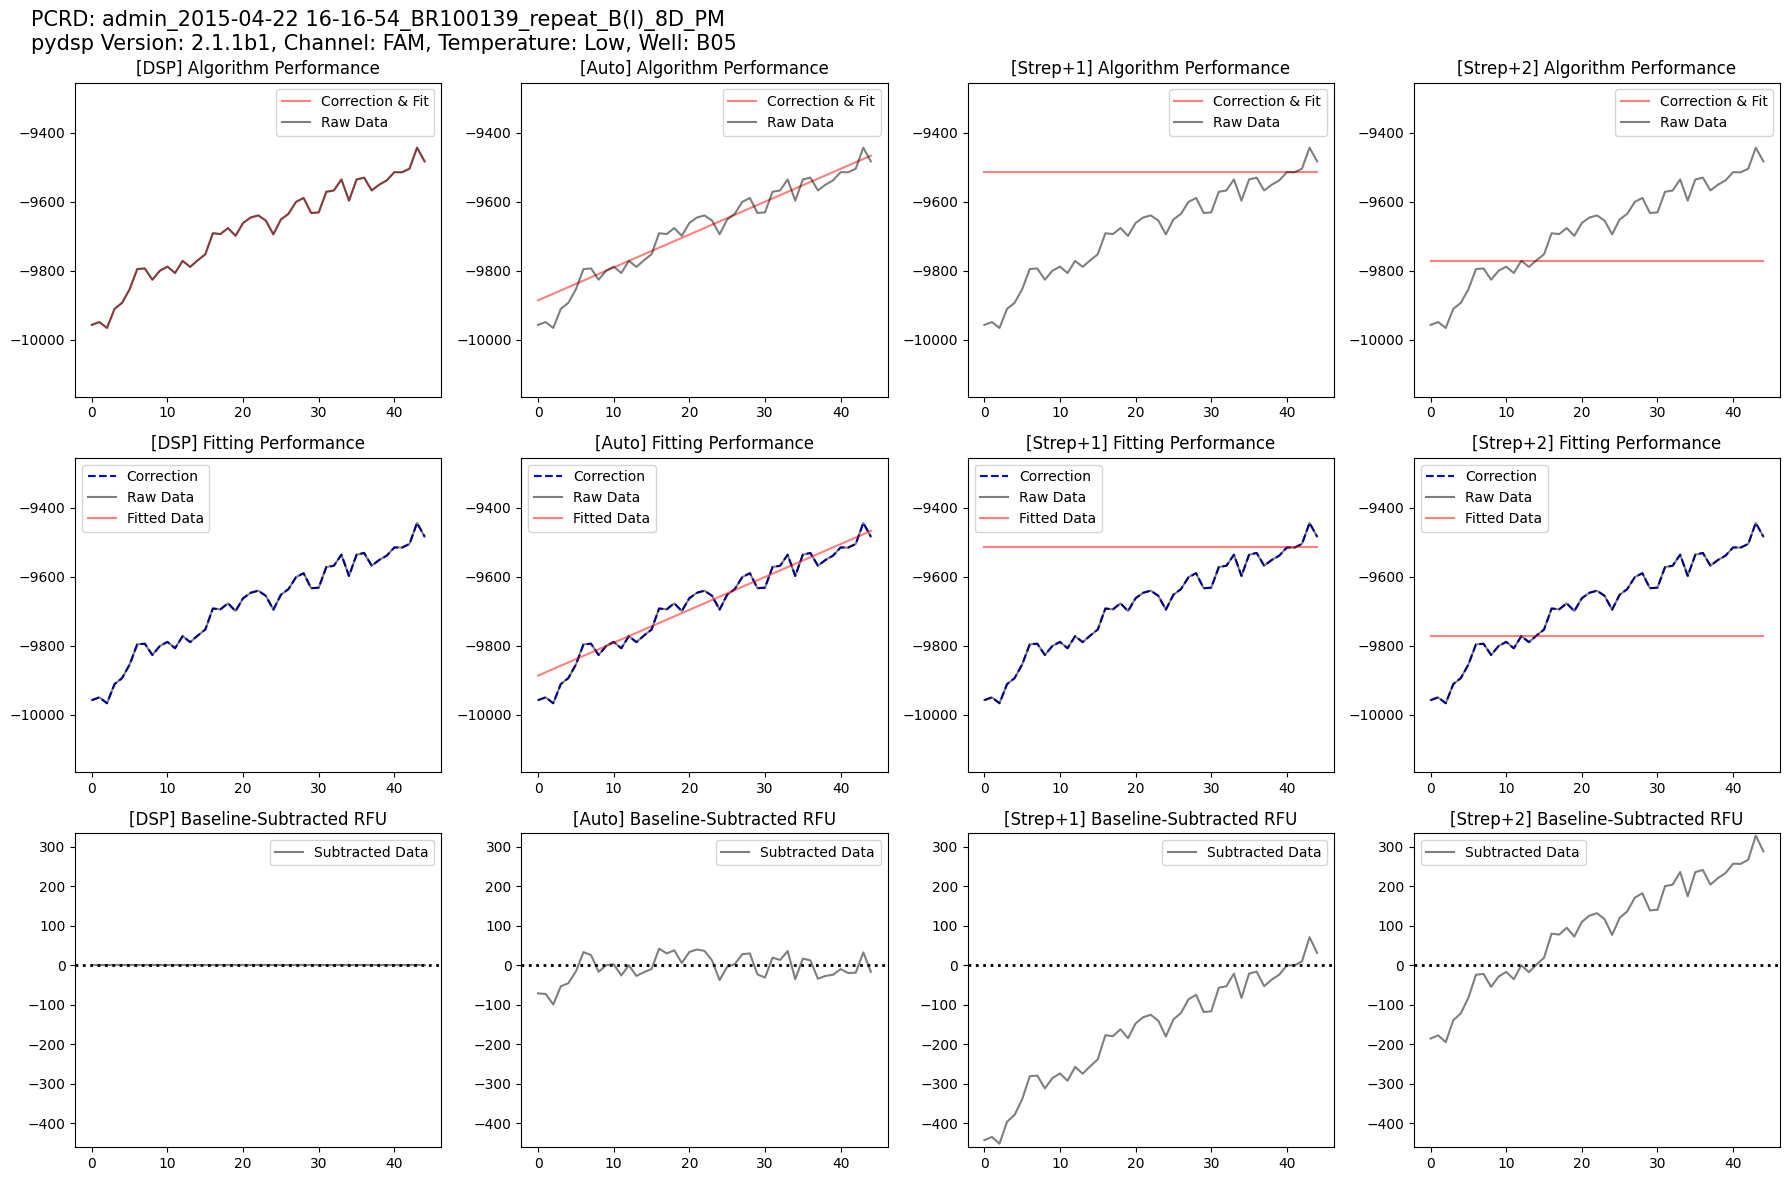

In [33]:
pcrd_nm = temp.loc[37896]['name']
channel_nm =temp.loc[37896]['channel']
temperature_nm=temp.loc[37896]['temperature']
well_nm=temp.loc[37896]['well']
plot_single_well(ascending_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

In [36]:
temp=ascending_data[ascending_data['strep_plus2_analysis_absd'].apply(lambda x: x[10]<-300)]
temp

original_rfu_cfx  \
21512  [208.155937331219, 124.105353737132, 91.645910...   
24312  [162.085074631019, 99.0378062403033, 72.396030...   
36192  [131.243790884146, 86.721815080773, 60.9974220...   
36200  [134.380403654917, 88.5103849806419, 66.632514...   
38952  [204.96796255677, 131.49549981676, 102.2529006...   
40088  [159.912783108211, 67.7124480391212, 73.558802...   

                                               combo_key  \
21512  admin_2015-03-18 05-45-04_CC009366_B(I)_D2_PRE...   
24312  admin_2015-03-23 10-09-22_CC009366_B(I)_D4-1 8...   
36192  admin_2015-04-16 10-58-14_CC013751_REPEAT_b(I)...   
36200  admin_2015-04-16 10-58-14_CC013751_REPEAT_b(I)...   
38952  admin_2015-04-24 10-45-53_BR100135_repeat_B(I)...   
40088  admin_2015-04-28 18-52-07_BR100139_repeat_B(I)...   

                                                    name   steps pcr_system  \
21512     admin_2015-03-18 05-45-04_CC009366_B(I)_D2_PRE  [4, 5]       None   
24312       admin_2015-03-23 10-09-22_CC009366_B(I)_D4-1  [4, 5]       None   
36192  admin_2015-04-16 10-58-14_CC013751_REPEAT_b(I)...  [4, 5]       None   
36200  admin_2015-04-16 10-58-14_CC013751_REPEAT_b(I)...  [4, 5]       None   
38952  admin_2015-04-24 10-45-53_BR100135_repeat_B(I)...  [4, 5]       None   
40088  admin_2015-04-28 18-52-07_BR100139_repeat_B(I)...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
21512    8-strip   Sample  F06     FAM         Low  ...   
24312    8-strip   Sample  C08     FAM         Low  ...   
36192    8-strip   Sample  D08     FAM         Low  ...   
36200    8-strip   Sample  D09     FAM         Low  ...   
38952    8-strip   Sample  F09     FAM         Low  ...   
40088    8-strip   Sample  F07     FAM         Low  ...   

                            strep_plus2_analysis_scd_fit  \
21512  [-10866.210151258501, -10866.210151258501, -10...   
24312  [-10472.5346852698, -10472.5346852698, -10472....   
36192  [-10785.5085927941, -10785.5085927941, -10785....   
36200  [-10969.451567419199, -10969.451567419199, -10...   
38952  [-13187.3353794092, -13187.3353794092, -13187....   
40088  [-10141.0986066584, -10141.0986066584, -10141....   

       strep_plus2_analysis_efc strep_plus2_final_ct  \
21512                        40                 -1.0   
24312                        40                 -1.0   
36192                        40                 -1.0   
36200                        40                 -1.0   
38952                        40                 -1.0   
40088                        37                 -1.0   

      strep_plus2_analysis_resultwell  strep_plus2_analysis_dataprocnum  \
21512                               1                                 8   
24312                               1                                 8   
36192                               1                                 8   
36200                               1                                 8   
38952                               1                                 8   
40088                               1                                 8   

                    outlier_naive_residuals_original_rfu  \
21512  [12019.6462713334, 11925.1065503648, 11882.157...   
24312  [12182.1495126644, 12107.9054303871, 12070.066...   
36192  [12221.2135113329, 12164.3283565263, 12126.240...   
36200  [12543.1333594529, 12483.1147481792, 12447.088...   
38952  [15080.4642014317, 14988.6338222524, 14941.033...   
40088  [11662.1350216688, 11557.5746183679, 11551.060...   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
21512                           1.825762                           2.412454   
24312                           1.849884                           2.412454   
36192                           1.686851                           2.412454   
36200                           1.622498                           2.412454   
38952                           1.641262                           2.41245

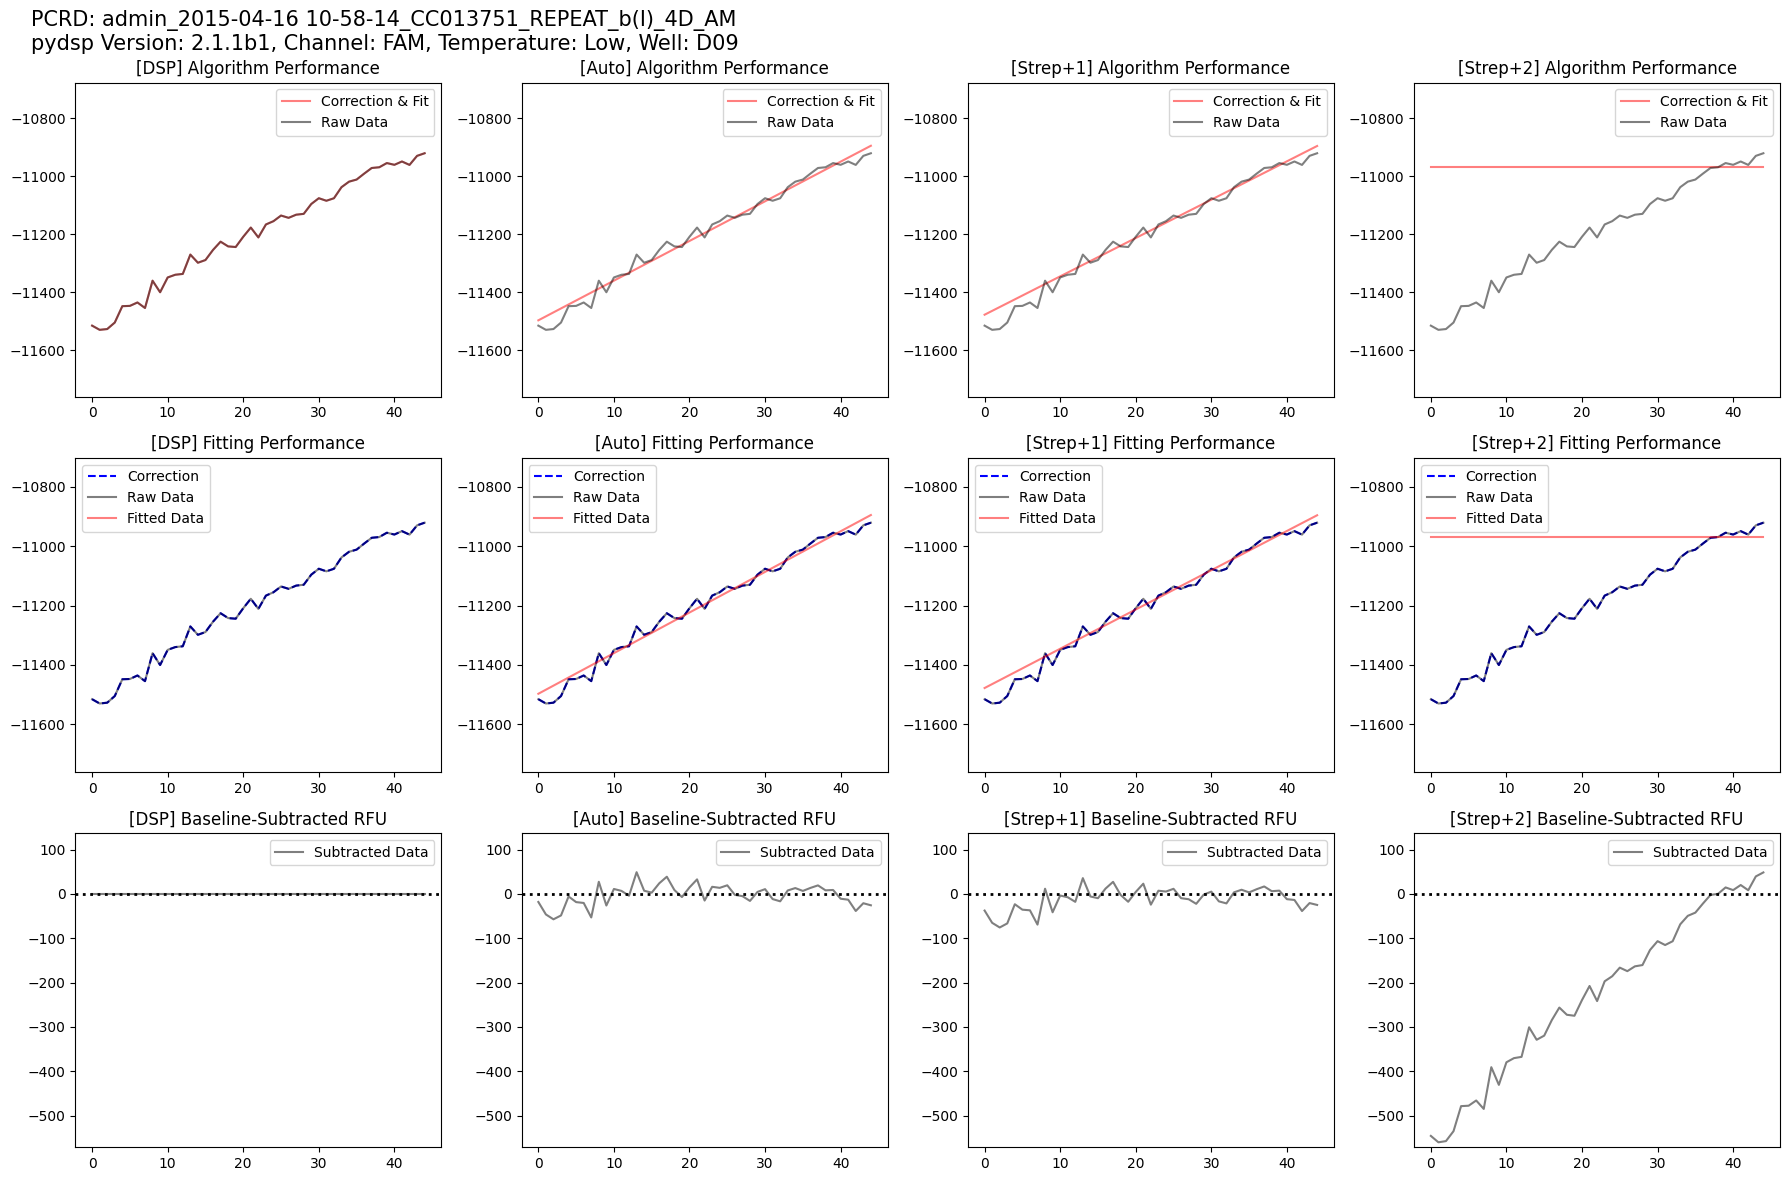

In [37]:
pcrd_nm = temp.loc[36200]['name']
channel_nm =temp.loc[36200]['channel']
temperature_nm=temp.loc[36200]['temperature']
well_nm=temp.loc[36200]['well']
plot_single_well(ascending_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

In [39]:
temp=ascending_data[ascending_data['strep_plus2_analysis_absd'].apply(lambda x: x[35]>200)]
temp

original_rfu_cfx  \
640    [191.40472828131, 121.471362422002, 87.5023230...   
1528   [98.9028741534366, 69.2397164514732, 63.393780...   
21288  [257.017003979247, 154.794704218109, 107.26571...   
23400  [190.109414911234, 117.675780587362, 105.49419...   
24584  [193.232347153324, 117.602590795132, 94.051508...   
24608  [194.595474965578, 136.663735464965, 89.283594...   
26648  [228.515569318257, 175.438701515317, 103.50630...   
26664  [230.266340906537, 111.657059562222, 103.67217...   
35432  [177.85478850135, 122.154197605805, 88.2143950...   
36480  [132.844811042069, 92.0871997475406, 72.547591...   
37896  [189.746023185144, 139.868046368645, 84.339588...   
38928  [101.696645846094, 68.9415206659305, 77.920351...   
39624  [127.458514931424, 56.6509733063467, 43.521960...   
40192  [140.050379328361, 84.9375454535129, 95.825722...   
40568  [224.040176119122, 143.573010746182, 100.20395...   
41208  [154.713510386373, 88.6328683753582, 78.006563...   
41592  [231.588938280529, 141.004459018981, 115.84756...   

                                               combo_key  \
640    2. admin_2017-05-22 14-06-05_BR101459 GI9801XY...   
1528   5. admin_2017-05-22 14-40-33_BR101645 GI9801XY...   
21288  admin_2015-03-18 05-45-04_CC009366_B(I)_D2_PRE...   
23400  admin_2015-03-20 23-12-44_CC009366_B(I)_D3-1 8...   
24584  admin_2015-03-23 10-09-22_CC009366_B(I)_D4-1 8...   
24608  admin_2015-03-23 10-09-22_CC009366_B(I)_D4-1 8...   
26648  admin_2015-03-25 08-32-59_CC013751_B(I)_D5 8-s...   
26664  admin_2015-03-25 08-32-59_CC013751_B(I)_D5 8-s...   
35432  admin_2015-04-14 10-50-37_BR100394_repeat_B(I)...   
36480  admin_2015-04-17 17-03-54_BR100396_repeat_B(I)...   
37896  admin_2015-04-22 16-16-54_BR100139_repeat_B(I)...   
38928  admin_2015-04-24 10-45-53_BR100135_repeat_B(I)...   
39624  admin_2015-04-27 18-46-45_CC010436_repeat_B(I)...   
40192  admin_2015-04-29 12-58-02_BR100135_repeat_B(I)...   
40568  admin_2015-05-06 10-58-54_CC009366_repeat_B(I)...   
41208  admin_2015-05-11 10-02-46_BR100386_repeat_B(I)...   
41592  admin_2015-05-11 17-45-31_CC013751_18D_PM 8-st...   

                                                    name   steps pcr_system  \
640    2. admin_2017-05-22 14-06-05_BR101459 GI9801XY...  [4, 5]       None   
1528   5. admin_2017-05-22 14-40-33_BR101645 GI9801XY...  [4, 5]       None   
21288     admin_2015-03-18 05-45-04_CC009366_B(I)_D2_PRE  [4, 5]       None   
23400       admin_2015-03-20 23-12-44_CC009366_B(I)_D3-1  [4, 5]       None   
24584       admin_2015-03-23 10-09-22_CC009366_B(I)_D4-1  [4, 5]       None   
24608       admin_2015-03-23 10-09-22_CC009366_B(I)_D4-1  [4, 5]       None   
26648         admin_2015-03-25 08-32-59_CC013751_B(I)_D5  [4, 5]       None   
26664         admin_2015-03-25 08-32-59_CC013751_B(I)_D5  [4, 5]       None   
35432  admin_2015-04-14 10-50-37_BR100394_repeat_B(I)...  [4, 5]       None   
36480  admin_2015-04-17 17-03-54_BR100396_repeat_B(I)...  [4, 5]       None   
37896  admin_2015-04-22 16-16-54_BR100139_repeat_B(I)...  [4, 5]       None   
38928  admin_2015-04-24 10-45-53_BR100135_repeat_B(I)...  [4, 5]       None   
39624  admin_2015-04-27 18-46-45_CC010436_repeat_B(I)...  [4, 5]       None   
40192  admin_2015-04-29 12-58-02_BR100135_repeat_B(I)...  [4, 5]       None   
40568  admin_2015-05-06 10-58-54_CC009366_repeat_B(I)...  [4, 5]       None   
41208  admin_2015-05-11 10-02-46_BR100386_repeat_B(I)...  [4, 5]       None   
41592          admin_2015-05-11 17-45-31_CC013751_18D_PM  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
640      8-strip       NC  H09     FAM         Low  ...   
1528     8-strip   Sample  C08     FAM         Low  ...   
21288    8-strip   Sample  D02     FAM         Low  ...   
23400    8-strip   Sample  B02     FAM         Low  ...   
24584    8-strip   Sample  F06     FAM         Low  ...   
24608    8-strip   Sample  F09     FAM         Low  ...   
26648    8-strip   Sample  F08     FAM    

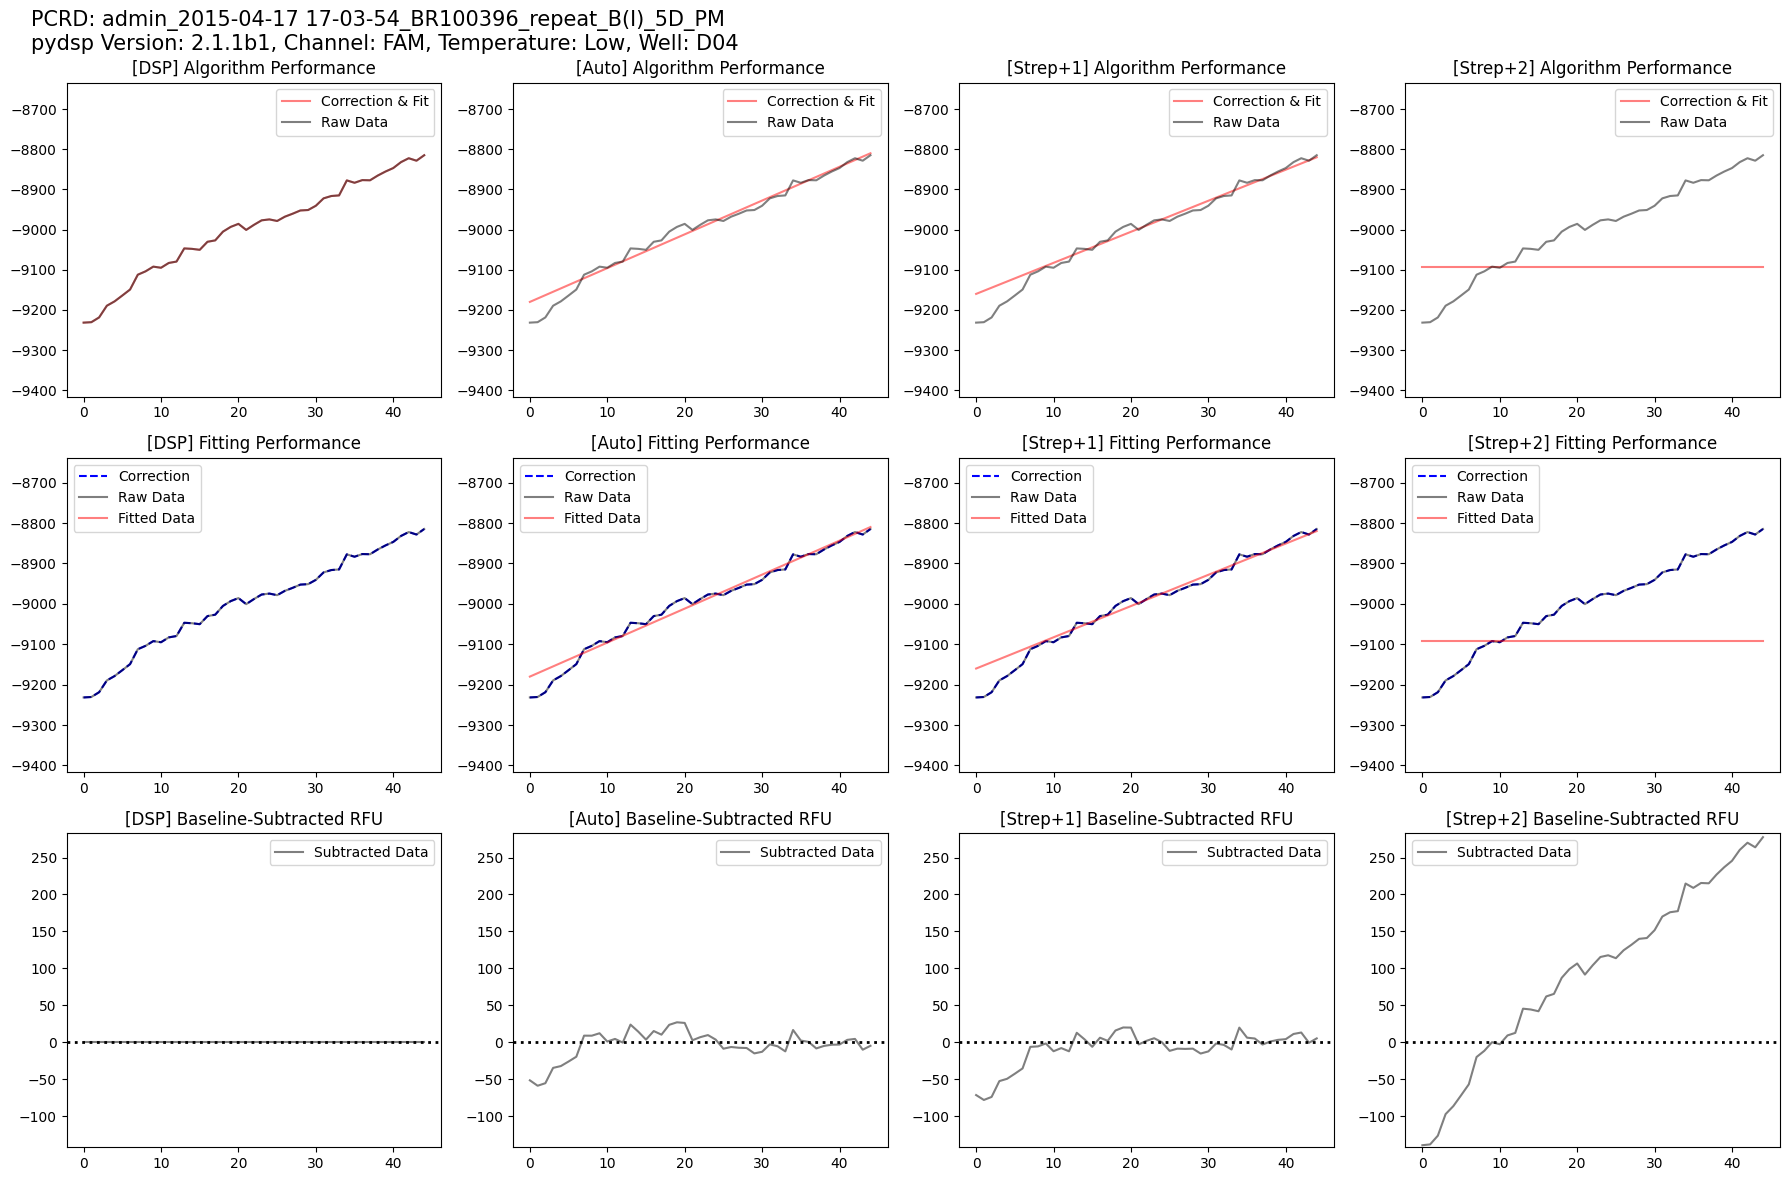

In [40]:
pcrd_nm = temp.loc[36480]['name']
channel_nm =temp.loc[36480]['channel']
temperature_nm=temp.loc[36480]['temperature']
well_nm=temp.loc[36480]['well']
plot_single_well(ascending_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

### 6. 감소 신호 패턴에 대한 복수 신호 시각화

In [8]:
descending_data = merged_data.query("`channel` == @channel_name & `temperature` == @temperature_name & `final_ct` <0 & `linear_slope` <0")
descending_data = descending_data.iloc[:len(descending_data) // 2]

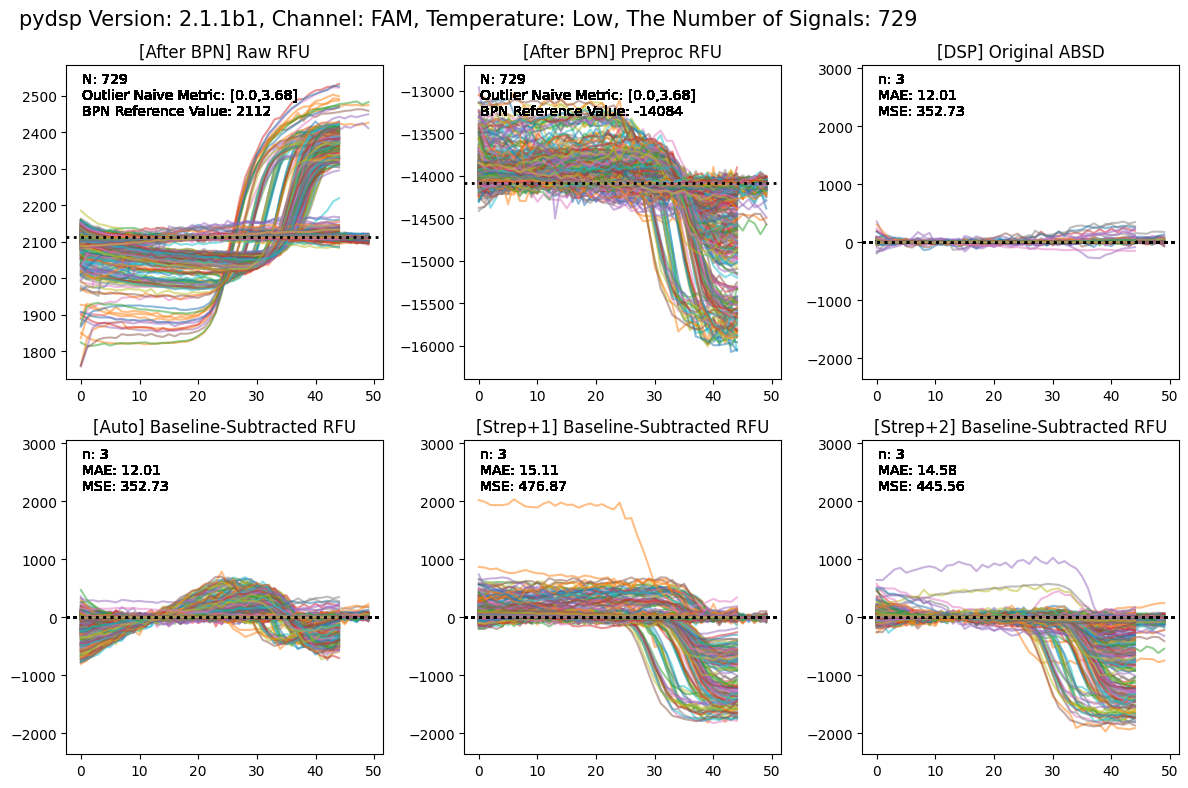

In [9]:
plot_signal_patterns(descending_data,channel_name, temperature_name, mudt = True)

In [13]:
descending_data = merged_data.query("`analysis_dataprocnum` == 13 & `channel` == @channel_name & `temperature` == @temperature_name & `final_ct` <0 & `linear_slope` <0")

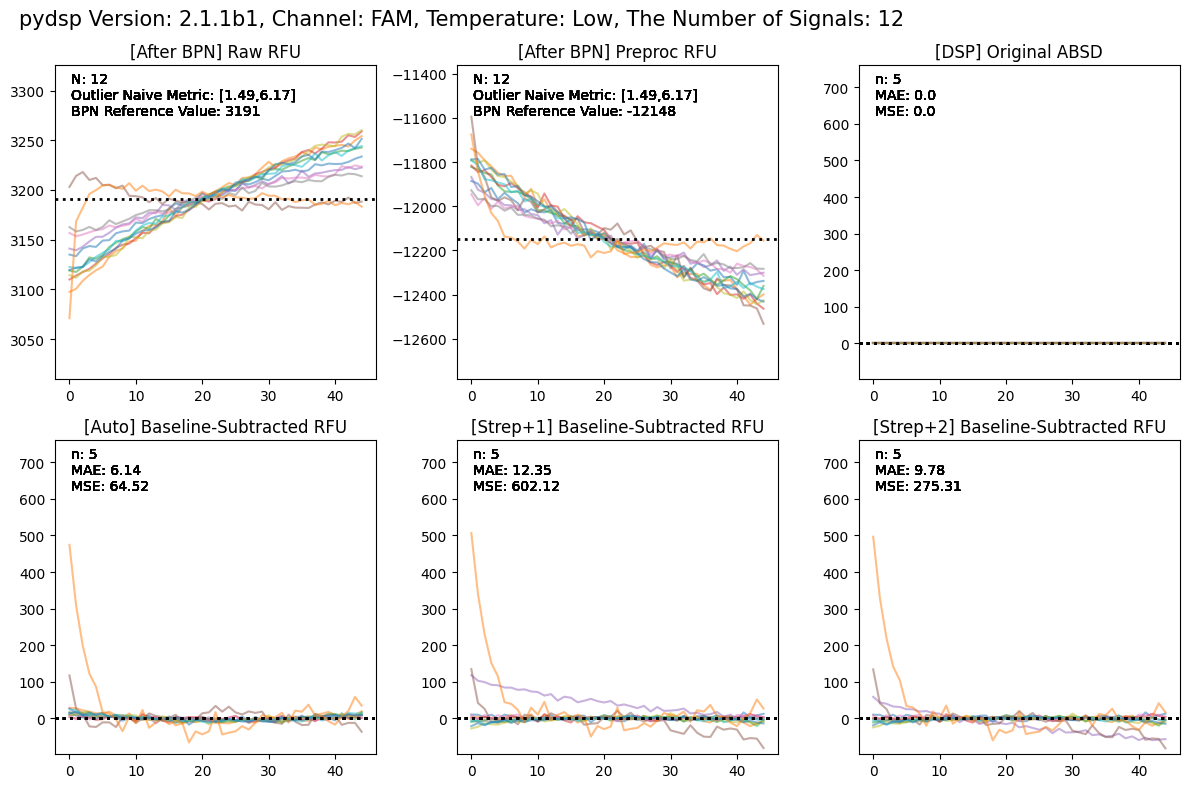

In [11]:
plot_signal_patterns(descending_data,channel_name, temperature_name, mudt = True)

In [43]:
temp=descending_data[descending_data['strep_plus2_analysis_absd'].apply(lambda x: x[35]<-50)]
temp

original_rfu_cfx  \
26112  [2.11532313015141, 20.5024805103949, 27.454383...   

                                               combo_key  \
26112  admin_2015-03-25 08-32-59_CC013751_B(I)_D5 8-s...   

                                             name   steps pcr_system  \
26112  admin_2015-03-25 08-32-59_CC013751_B(I)_D5  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
26112    8-strip   Sample  A01     FAM         Low  ...   

                            strep_plus2_analysis_scd_fit  \
26112  [-5096.298120013067, -5100.514537421612, -5104...   

       strep_plus2_analysis_efc strep_plus2_final_ct  \
26112                        28                 -1.0   

      strep_plus2_analysis_resultwell  strep_plus2_analysis_dataprocnum  \
26112                               1                                 8   

                    outlier_naive_residuals_original_rfu  \
26112  [5098.4103461604, 5104.57550694011, 5091.95073...   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
26112                           1.976339                           2.412454   

       outlier_naive_metric_percentile_original_rfu linear_slope  
26112                                          75.0    -0.153062  

[1 rows x 89 columns]

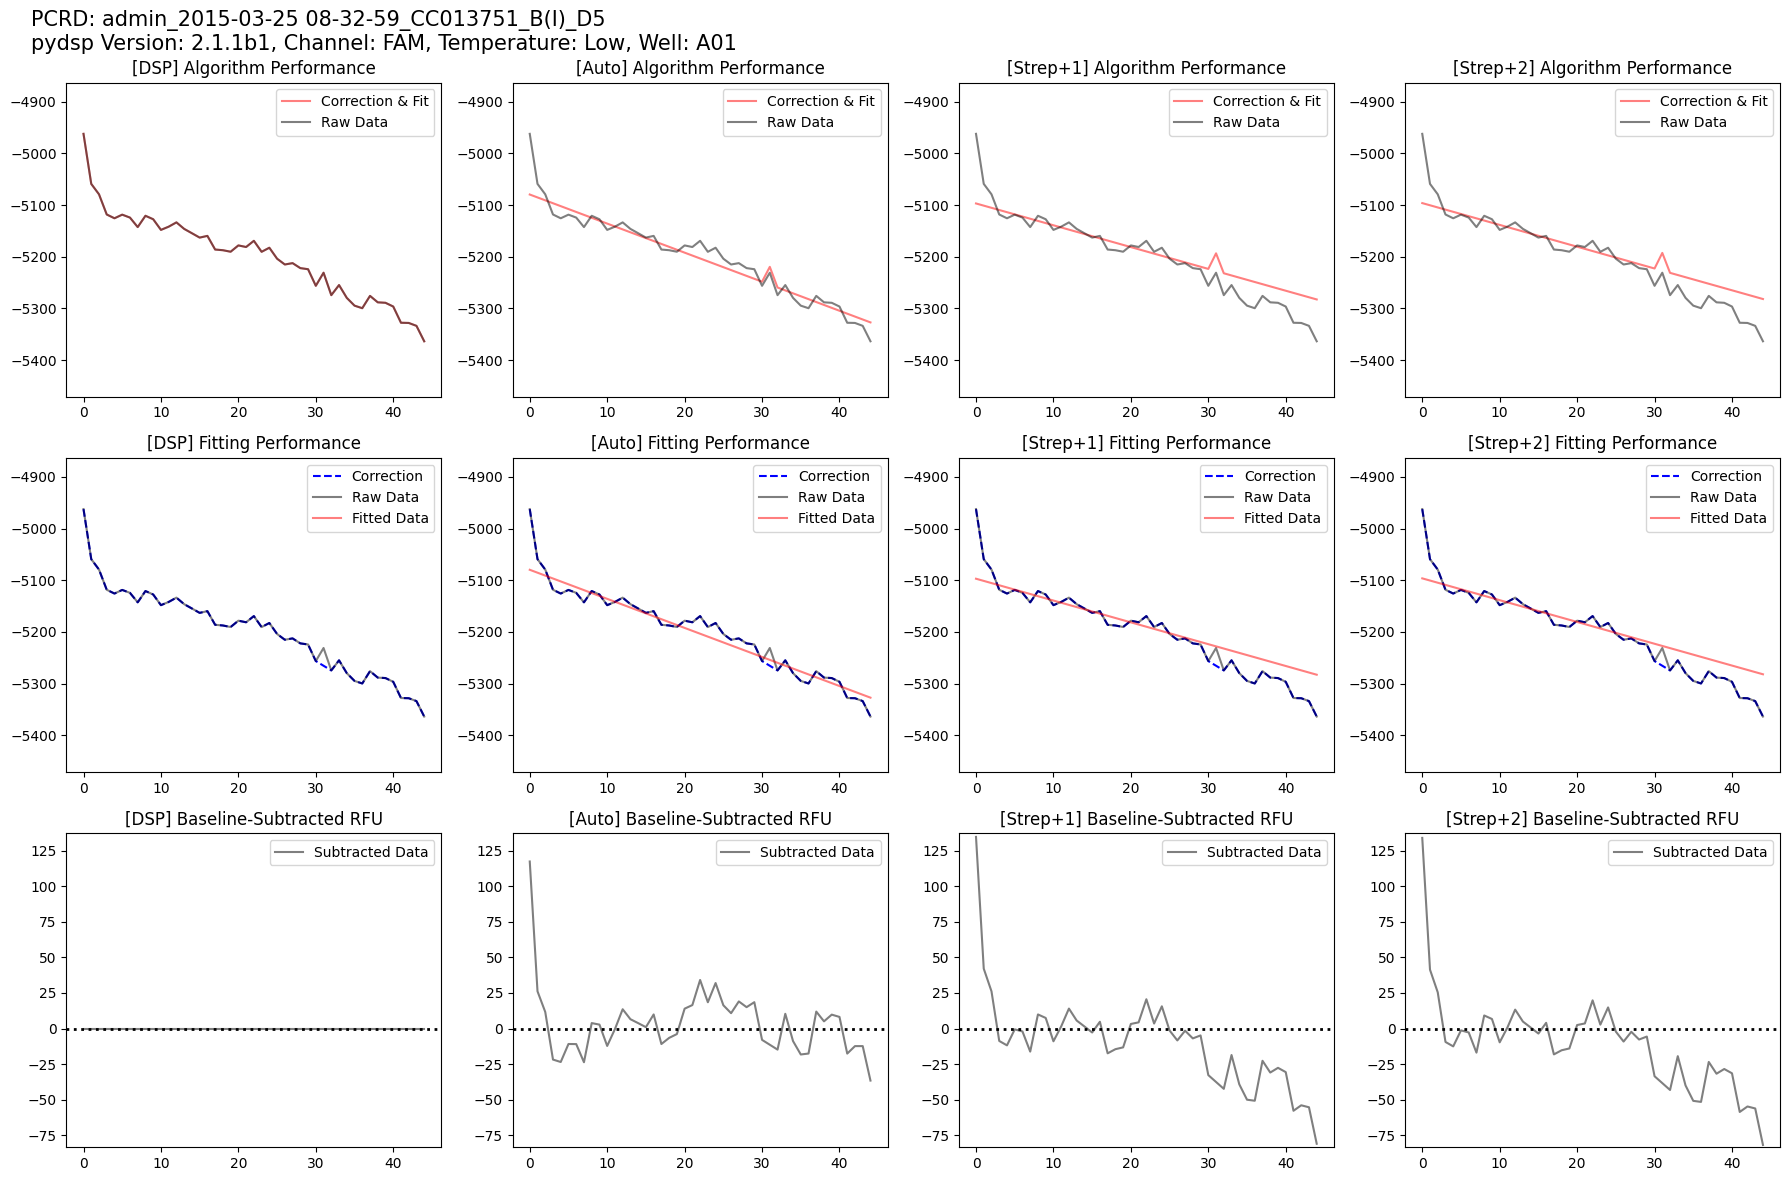

In [47]:
pcrd_nm = temp.loc[26112]['name']
channel_nm =temp.loc[26112]['channel']
temperature_nm=temp.loc[26112]['temperature']
well_nm=temp.loc[26112]['well']
plot_single_well(descending_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

In [16]:
temp=descending_data[descending_data['strep_plus2_analysis_absd'].apply(lambda x: x[2]>200)]
temp

original_rfu_cfx  \
42416  [-550.82717642339, -142.870816256274, -84.5826...   

                                               combo_key  \
42416  admin_2015-05-12 18-35-57_CC013751_repeat_B(I)...   

                                                    name   steps pcr_system  \
42416  admin_2015-05-12 18-35-57_CC013751_repeat_B(I)...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
42416    8-strip   Sample  G02     FAM         Low  ...   

                            strep_plus2_analysis_scd_fit  \
42416  [-12171.694348799898, -12171.694348799898, -12...   

       strep_plus2_analysis_efc strep_plus2_final_ct  \
42416                        43                 -1.0   

      strep_plus2_analysis_resultwell  strep_plus2_analysis_dataprocnum  \
42416                               1                                 8   

       outlier_naive_residuals_original_rfu  \
42416                    [12816.4060164355]   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
42416                            6.16582                           2.412454   

       outlier_naive_metric_percentile_original_rfu linear_slope  
42416                                         100.0    -0.064367  

[1 rows x 89 columns]

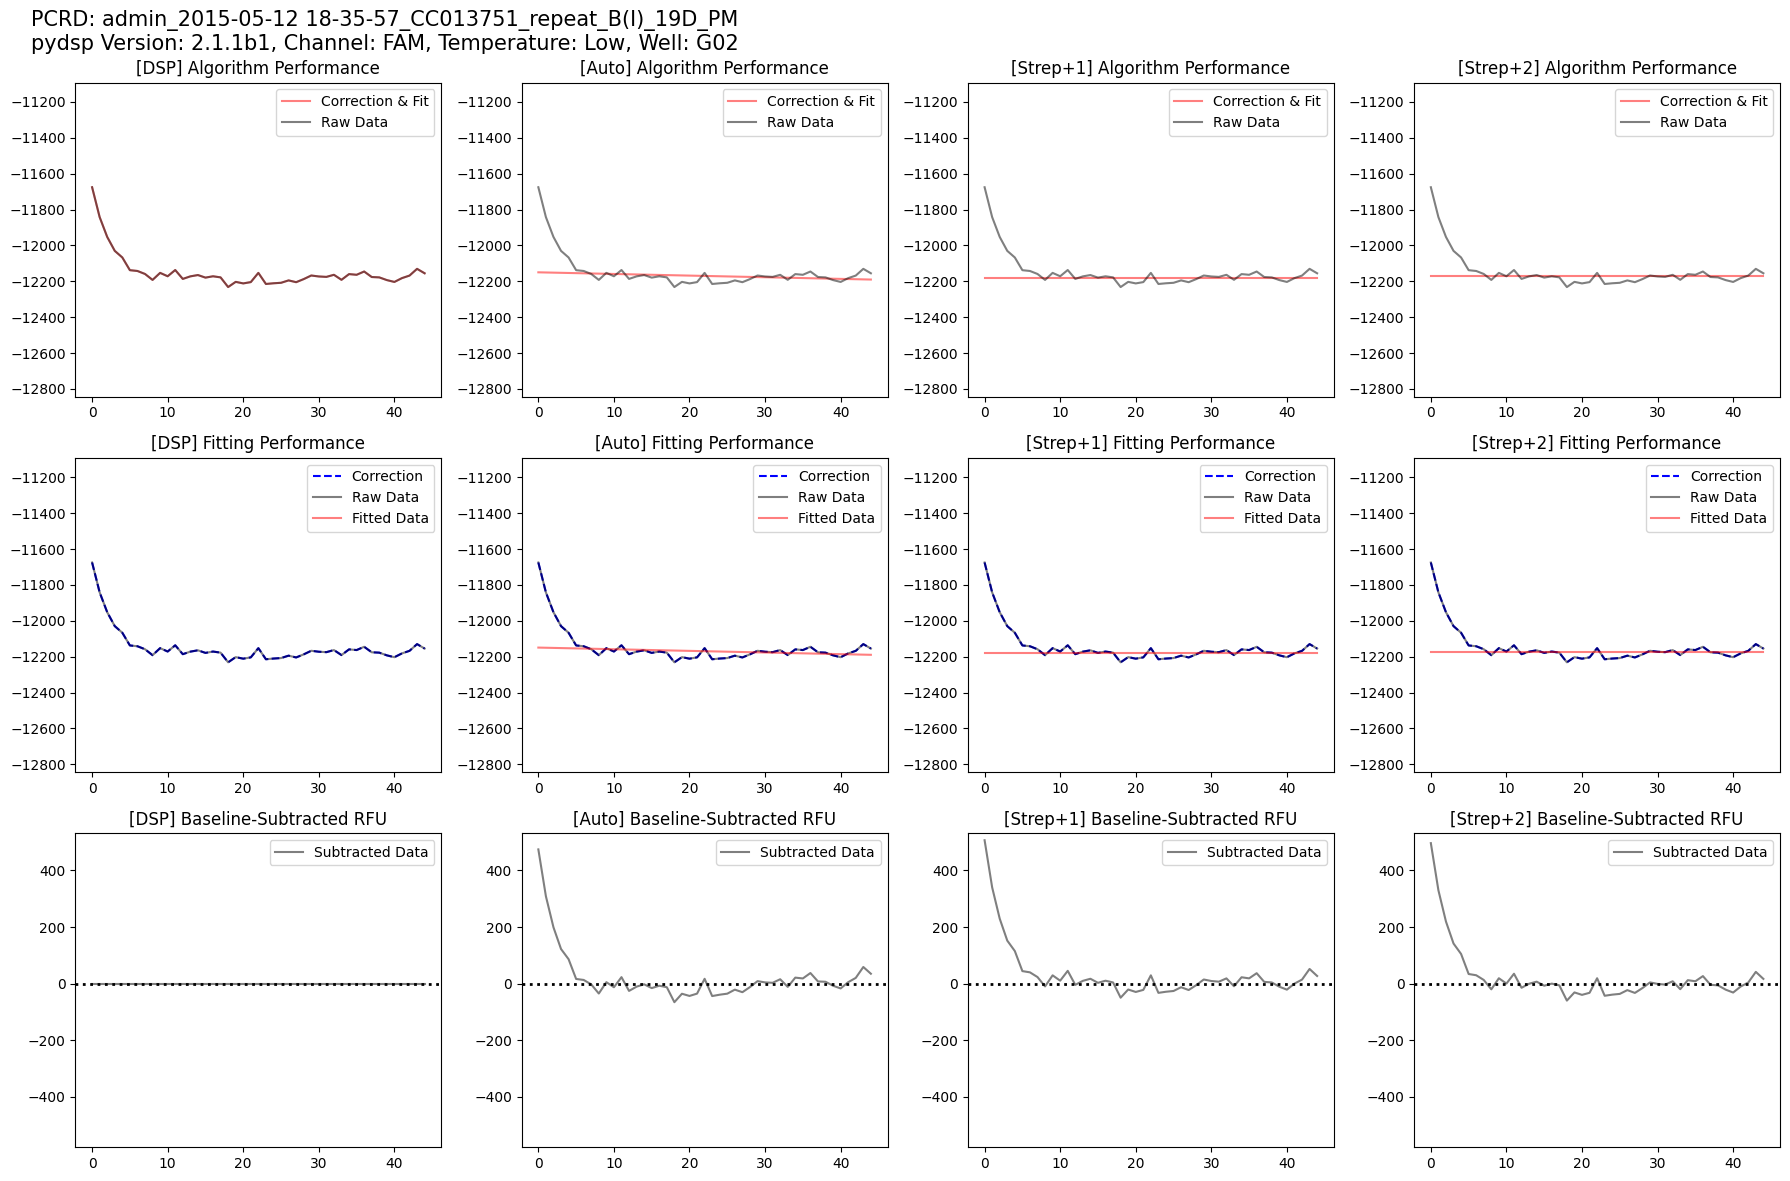

In [17]:
pcrd_nm = temp.loc[42416]['name']
channel_nm =temp.loc[42416]['channel']
temperature_nm=temp.loc[42416]['temperature']
well_nm=temp.loc[42416]['well']
plot_single_well(descending_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

### 7. MuDT 왜곡 신호에 대한 복수 신호 시각화

In [3]:
merged_data['mudt_distortion_combo_key']=merged_data[['name', 'channel', 'well']].apply(lambda x: ' '.join(x), axis=1)
mudt_high_risk_list = merged_data.query("`temperature`=='High' & `final_ct`<40 & `final_ct`>0")['mudt_distortion_combo_key'].unique()
mudt_risk_data=merged_data.query("`mudt_distortion_combo_key` in @mudt_high_risk_list & `temperature`=='Low' & `final_ct`<0")

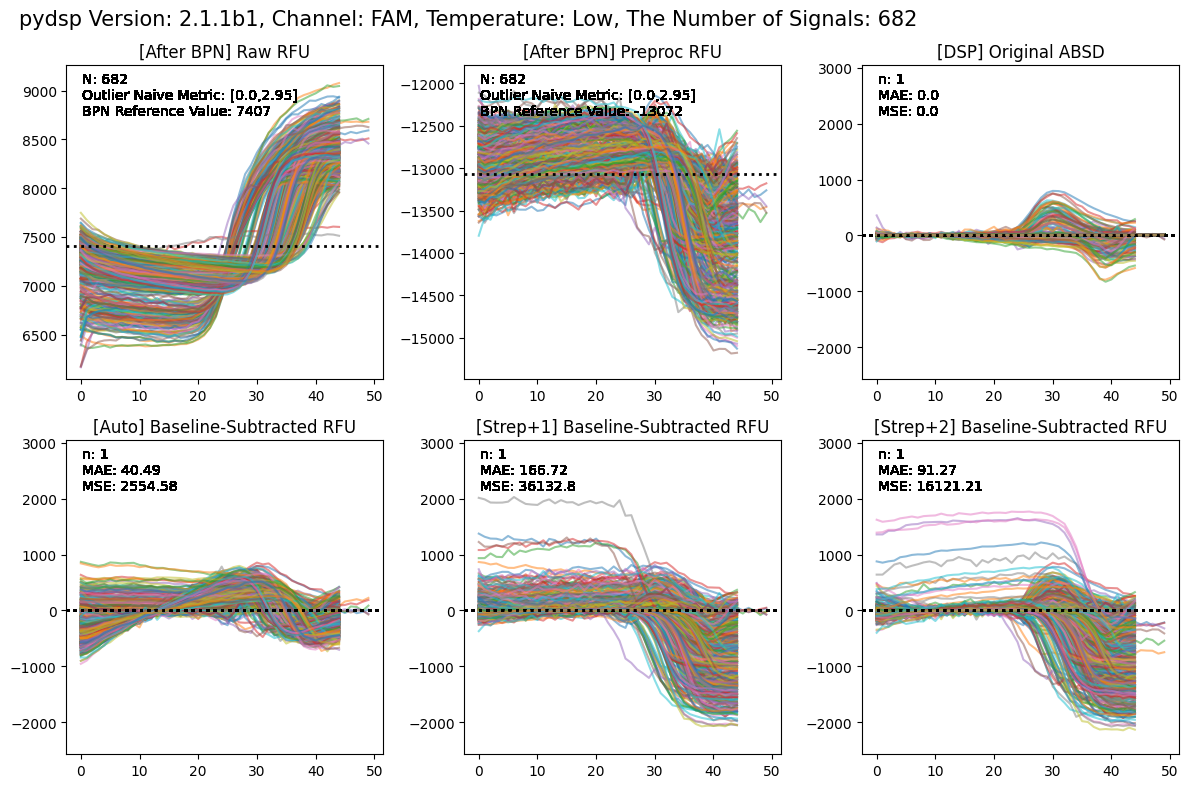

In [10]:
plot_signal_patterns(mudt_risk_data, channel_name, temperature_name, mudt=mudt)

In [4]:
temp=mudt_risk_data[mudt_risk_data['strep_plus2_analysis_absd'].apply(lambda x: x[20]>1000)]
temp

original_rfu_cfx  \
54384  [213.226214639708, 162.726140473083, 90.452427...   
54400  [129.283204321366, 86.7919776115486, 40.101885...   
58446  [187.155724197135, 93.5351626229021, 59.639453...   
61864  [180.856471029996, 113.301523811389, 62.488619...   

                                               combo_key  \
54384  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...   
54400  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...   
58446  admin_2017-02-20 11-32-22_BR100558 GI9801XY MO...   
61864  admin_2017-05-29 14-33-14_BR101472 GI9801XY MO...   

                                                    name   steps pcr_system  \
54384  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  [4, 5]       None   
54400  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  [4, 5]       None   
58446  admin_2017-02-20 11-32-22_BR100558 GI9801XY MO...  [4, 5]       None   
61864  admin_2017-05-29 14-33-14_BR101472 GI9801XY MO...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
54384    8-strip   Sample  B05     FAM         Low  ...   
54400    8-strip   Sample  B07     FAM         Low  ...   
58446    8-strip   Sample  B08     FAM         Low  ...   
61864    8-strip   Sample  H02     FAM         Low  ...   

      strep_plus2_analysis_efc  strep_plus2_final_ct  \
54384                       40                  -1.0   
54400                       40                  -1.0   
58446                       40                  -1.0   
61864                       40                  -1.0   

      strep_plus2_analysis_resultwell strep_plus2_analysis_dataprocnum  \
54384                               1                                8   
54400                               1                                8   
58446                               1                                8   
61864                               1                                8   

                    outlier_naive_residuals_original_rfu  \
54384  [13550.4088570495, 13849.5428313364, 14020.663...   
54400  [12937.2283479932, 13293.6521206563, 13481.607...   
58446  [13217.2184961768, 13411.7822756436, 13517.304...   
61864  [10323.9759027901, 10469.784853698, 10552.4299...   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
54384                           1.910652                           2.412454   
54400                           1.919622                           2.412454   
58446                           2.003267                           2.412454   
61864                           1.980166                           2.412454   

       outlier_naive_metric_percentile_original_rfu  linear_slope  \
54384                                          68.5     -0.014946   
54400                                          69.3     -0.013695   
58446                                          77.5     -0.014260   
61864                                          75.4     -0.017590   

                               mudt_distortion_combo_key  
54384  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  
54400  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  
58446  admin_2017-02-20 11-32-22_BR100558 GI9801XY MO...  
61864  admin_2017-05-29 14-33-14_BR101472 GI9801XY MO...  

[4 rows x 90 columns]

/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) miss

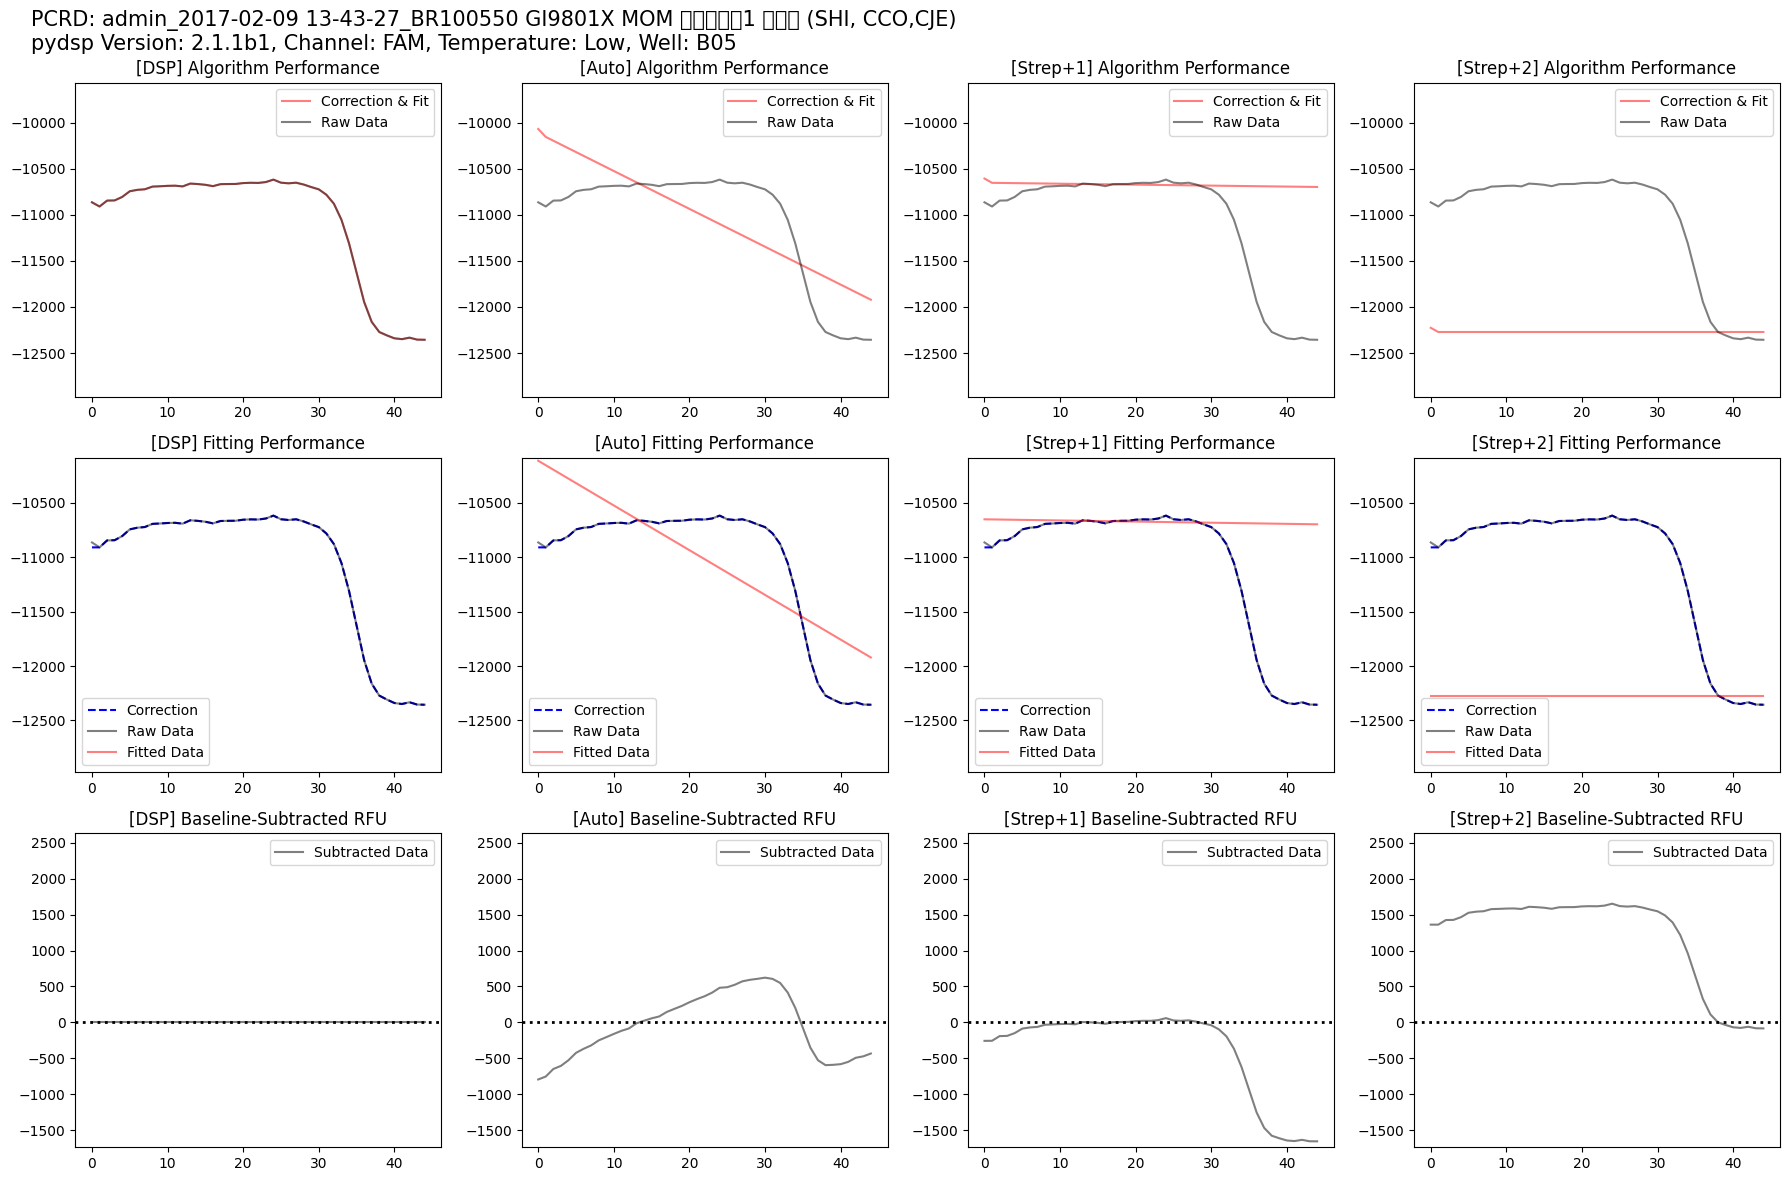

In [5]:
pcrd_nm = temp.loc[54384]['name']
channel_nm =temp.loc[54384]['channel']
temperature_nm=temp.loc[54384]['temperature']
well_nm=temp.loc[54384]['well']
plot_single_well(mudt_risk_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

In [8]:
temp=mudt_risk_data[mudt_risk_data['strep_plus1_analysis_absd'].apply(lambda x: x[20]>1000)]
temp

original_rfu_cfx  \
24912  [89.5818213195998, 47.1299358588494, 29.582925...   
50208  [12.4726566033914, 19.5811756046078, 17.717095...   
50488  [104.25327256016, 43.1422021575545, 29.8478767...   
50496  [82.5096797385268, 11.7961379432491, 12.261045...   
50808  [168.930063407593, 87.0377777410104, 60.811941...   

                                               combo_key  \
24912  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...   
50208  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...   
50488  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...   
50496  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...   
50808  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...   

                                                    name   steps pcr_system  \
24912  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...  [4, 5]       None   
50208  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  [4, 5]       None   
50488  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  [4, 5]       None   
50496  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  [4, 5]       None   
50808  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
24912    8-strip   Sample  B03     FAM         Low  ...   
50208    8-strip   Sample  A11     FAM         Low  ...   
50488    8-strip   Sample  D10     FAM         Low  ...   
50496    8-strip   Sample  D11     FAM         Low  ...   
50808    8-strip   Sample  H02     FAM         Low  ...   

      strep_plus2_analysis_efc  strep_plus2_final_ct  \
24912                       25                  -1.0   
50208                       24                  -1.0   
50488                       24                  -1.0   
50496                       24                  -1.0   
50808                       43                  -1.0   

      strep_plus2_analysis_resultwell strep_plus2_analysis_dataprocnum  \
24912                               1                                8   
50208                               1                                8   
50488                               1                                8   
50496                               1                                8   
50808                               1                                8   

                    outlier_naive_residuals_original_rfu  \
24912  [12576.7336718521, 12647.817708902, 12671.6523...   
50208  [12353.8371761792, 12392.5423246463, 12393.553...   
50488  [13373.1632256324, 13420.9503544931, 13440.493...   
50496  [13774.780449817, 13793.1932610697, 13803.6551...   
50808                                                 []   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
24912                           1.430359                           2.412454   
50208                           1.338279                           2.412454   
50488                           1.390584                           2.412454   
50496                           1.354094                           2.412454   
50808                           0.000000                           2.412454   

       outlier_naive_metric_percentile_original_rfu  linear_slope  \
24912                                           0.4     -0.013645   
50208                                           0.0     -0.020665   
50488                                           0.1     -0.021172   
50496                                           0.1     -0.019429   
50808                                           NaN     -0.019779   

                               mudt_distortion_combo_key  
24912  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...  
50208  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  
50488  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  
50496  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  
50808  admin_2015-12-17 10-10-31_CC010436_GI-B(I)_cli...  

[5 rows x 90 columns]

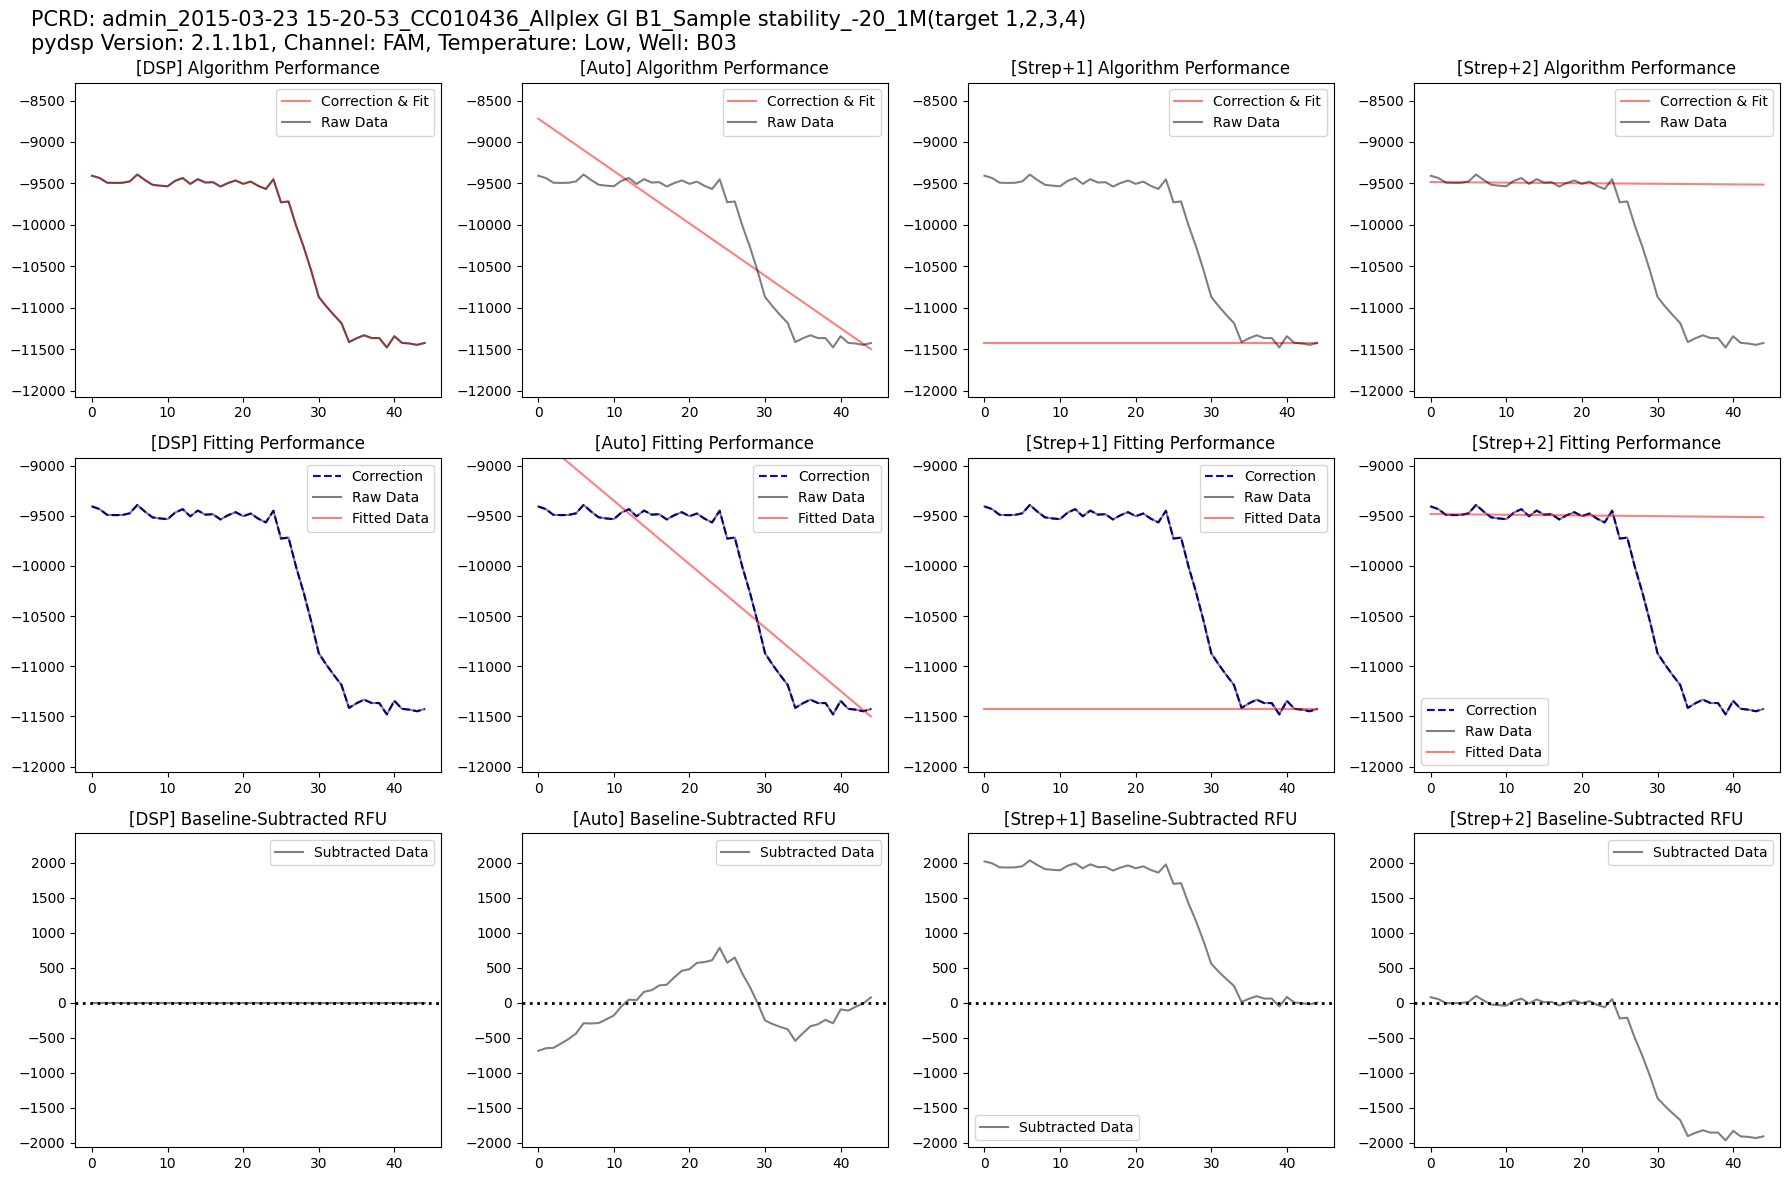

In [9]:
pcrd_nm = temp.loc[24912]['name']
channel_nm =temp.loc[24912]['channel']
temperature_nm=temp.loc[24912]['temperature']
well_nm=temp.loc[24912]['well']
plot_single_well(mudt_risk_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)

In [10]:
temp=mudt_risk_data[mudt_risk_data['strep_plus2_analysis_absd'].apply(lambda x: x[35]<-1800)]
temp

original_rfu_cfx  \
24912  [89.5818213195998, 47.1299358588494, 29.582925...   
24976  [62.7588729687959, 37.4870214793627, 13.113423...   
54288  [211.888075750789, 143.04870135646, 54.7374346...   
54296  [146.899004128283, 103.426830322789, 58.317884...   
54304  [142.334512300913, 83.9706766750587, 35.249323...   
54312  [168.393988471262, 80.0392296869068, 43.054947...   

                                               combo_key  \
24912  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...   
24976  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...   
54288  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...   
54296  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...   
54304  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...   
54312  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...   

                                                    name   steps pcr_system  \
24912  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...  [4, 5]       None   
24976  admin_2015-03-23 15-20-53_CC010436_Allplex GI ...  [4, 5]       None   
54288  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  [4, 5]       None   
54296  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  [4, 5]       None   
54304  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  [4, 5]       None   
54312  admin_2017-02-09 13-43-27_BR100550 GI9801X MOM...  [4, 5]       None   

      consumable welltype well channel temperature  ...  \
24912    8-strip   Sample  B03     FAM         Low  ...   
24976    8-strip   Sample  C03     FAM         Low  ...   
54288    8-strip   Sample  A05     FAM         Low  ...   
54296    8-strip   Sample  A06     FAM         Low  ...   
54304    8-strip   Sample  A07     FAM         Low  ...   
54312    8-strip   Sample  A08     FAM         Low  ...   

      strep_plus2_analysis_efc  strep_plus2_final_ct  \
24912                       25                  -1.0   
24976                       25                  -1.0   
54288                       28                  -1.0   
54296                       28                  -1.0   
54304                       27                  -1.0   
54312                       27                  -1.0   

      strep_plus2_analysis_resultwell strep_plus2_analysis_dataprocnum  \
24912                               1                                8   
24976                               1                                8   
54288                               1                                8   
54296                               1                                8   
54304                               1                                8   
54312                               1                                8   

                    outlier_naive_residuals_original_rfu  \
24912  [12576.7336718521, 12647.817708902, 12671.6523...   
24976  [13044.2840555994, 13130.0222903567, 13142.424...   
54288  [13742.998656209, 13886.5225822098, 13954.9659...   
54296  [13928.2626810248, 14065.0599379471, 14151.318...   
54304  [13365.4957904701, 13472.1366912625, 13565.903...   
54312  [12567.0014834015, 12687.255149382, 12759.8815...   

       outlier_naive_metric_original_rfu  outlier_naive_cutoff_original_rfu  \
24912                           1.430359                           2.412454   
24976                           1.421110                           2.412454   
54288                           1.626464                           2.412454   
54296                           1.625518                           2.412454   
54304                           1.621813                           2.412454   
54312                           1.617493                           2.412454   

       outlier_naive_metric_percentile_original_rfu  linear_slope  \
24912                                           0.4     -0.013645   
24976                                           0.3     -0.013231   
54288                                          13.1     -0.012856   
54296                                          12.9     -0.012767  

/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()
/home/jupyter-kmkim/dsp-research-strep-a/kkm/package/visualization.py:458: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) miss

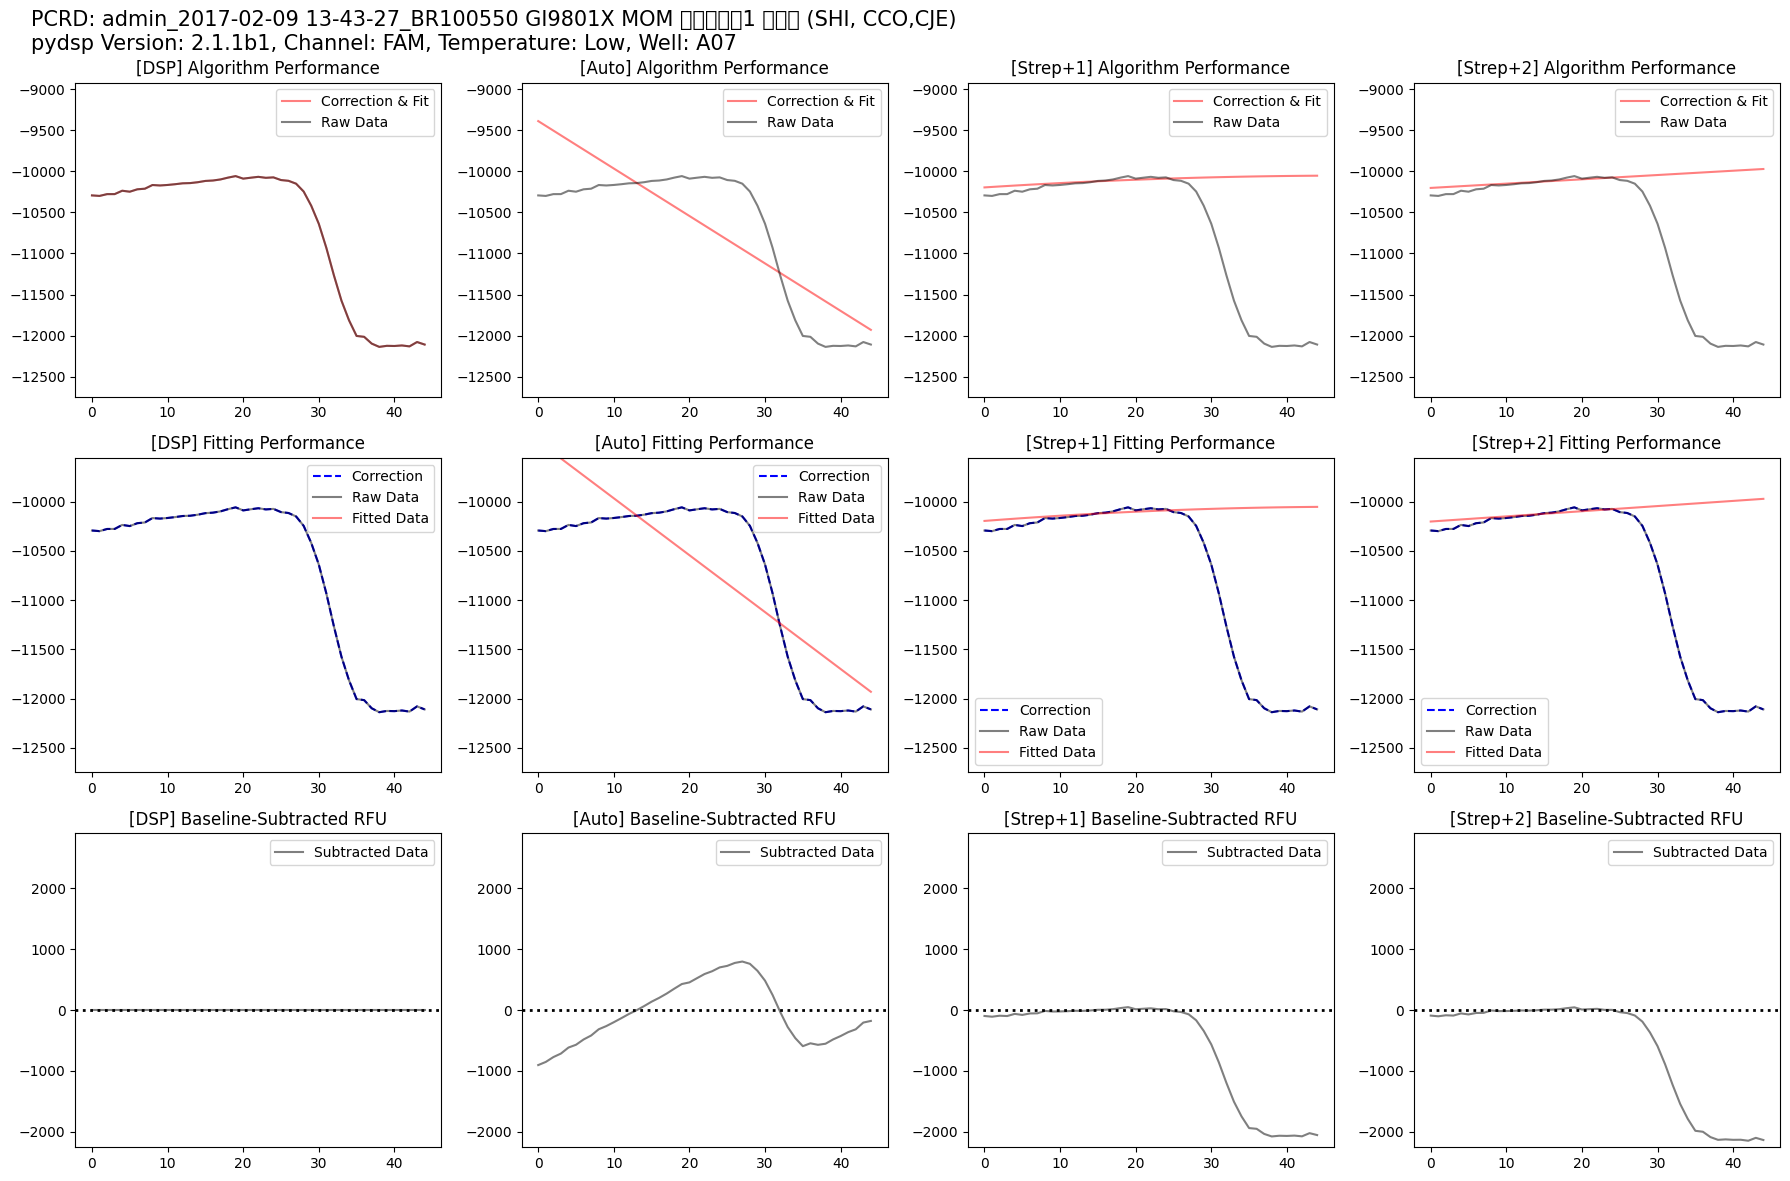

In [11]:
pcrd_nm = temp.loc[54304]['name']
channel_nm =temp.loc[54304]['channel']
temperature_nm=temp.loc[54304]['temperature']
well_nm=temp.loc[54304]['well']
plot_single_well(mudt_risk_data,pcrd_nm,channel_nm, temperature_nm, well_nm,mudt=mudt)